In [1]:
import os
import re
import openpyxl
import xlsxwriter
import csv
import pandas as pd
from datetime import datetime
import pandas as pd
import matplotlib.patches as patches
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import resample
from scipy.stats import pearsonr
import pickle
import seaborn as sns
import matplotlib as mpl
from typing import List, Dict, Optional
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Define helper functions

In [ ]:
def save_dataframe_to_files(df, pathname, filename):
    """
    Save a pandas DataFrame to both CSV and Excel formats in the specified location.
    Creates directories if they don't exist.
    """
    # Ensure the filename doesn't include extensions
    base_name = os.path.splitext(filename)[0]
    
    # Create directory if it doesn't exist
    os.makedirs(pathname, exist_ok=True)
    
    # Create full paths
    csv_path = os.path.join(pathname, f"{base_name}.csv")
    excel_path = os.path.join(pathname, f"{base_name}.xlsx")
    
    try:
        # Save files
        df.to_csv(csv_path, index=False)
        df.to_excel(excel_path, index=False, engine='openpyxl')
        
        print(f"Files saved successfully:\n- {csv_path}\n- {excel_path}")
    except Exception as e:
        print(f"Error saving files: {str(e)}")

In [3]:
def get_bootstrap_ci(bootstrap_distribution, confidence_level=0.95):
    alpha = 1 - confidence_level
    lower = np.percentile(bootstrap_distribution, (alpha / 2) * 100).round(3)
    upper = np.percentile(bootstrap_distribution, (1 - alpha / 2) * 100).round(3)
    mean = np.mean(bootstrap_distribution).round(3)
    median = np.median(bootstrap_distribution).round(3)
    std = np.std(bootstrap_distribution).round(3)
    
    return {
        'Mean': mean,
        'Median': median,
        'Std': std,
        'CI_lower': lower,
        'CI_upper': upper
    }

In [ ]:
def compute_and_save_bootstrap_results_1level(
    metrics: List[str],
    modality_name: str,
    base_path: str,
    output_path: str,
    ci_level: float = 0.95,
    column_order: Optional[List[str]] = None,
    print_summary: bool = True
) -> pd.DataFrame:
    
    # Default column order
    if column_order is None:
        column_order = ['Modality', 'Metric', 'Mean', 'Median', 'Std', 'CI_lower', 'CI_upper']
    
    ci_results = []
    
    for metric in metrics:
        # Load bootstrap results
        try:
            file_path = os.path.join(base_path, f"{modality_name}_{metric}_bootstrapped_renamed.csv")
            df = pd.read_csv(file_path)
            
            # Clean columns
            df = df.drop(
                columns=df.columns[df.columns.str.contains('^Unnamed|^index$', case=False)], 
                errors='ignore'
            )
            
        except FileNotFoundError:
            print(f"Warning: File not found for {modality_name}_{metric}")
            continue
        
        # Process each modality column
        for modality in df.columns:
            if df[modality].isna().all():
                print(f"Skipping empty modality: {modality}")
                continue
                
            values = df[modality].values
            lower, upper = get_bootstrap_ci(values, ci_level)
            
            ci_results.append({
                'Modality': modality,
                'Metric': metric.upper(),
                'Mean': np.mean(values).round(3),
                'Median': np.median(values).round(3),
                'Std': np.std(values).round(3),
                'CI_lower': lower,
                'CI_upper': upper
            })
    
    # Create and format DataFrame
    ci_df = pd.DataFrame(ci_results)
    
    # Ensure all expected columns exist
    missing_cols = [col for col in column_order if col not in ci_df.columns]
    if missing_cols:
        raise ValueError(f"Missing expected columns: {missing_cols}")
    
    ci_df = ci_df[column_order]
    
    # Save results
    output_filename = f'bootstrap_{modality_name}_pls_CI'
    save_dataframe_to_files(ci_df, output_path, output_filename)
    
    # Print results
    if print_summary:
        print_results(ci_df, output_path)
    
    return ci_df


def print_results(ci_df: pd.DataFrame, output_path: str) -> None:
    """Print formatted results summary."""
    print("=== Confidence Intervals ===")
    print(ci_df)
    print(f"\nResults saved to: {output_path}")
    
    for modality, group in ci_df.groupby('Modality'):
        print(f"\n=== {modality} ===")
        for metric, metric_group in group.groupby('Metric'):
            row = metric_group.iloc[0]
            print(f"{row['Metric']}:")
            print(f"  Mean ± SD: {row['Mean']} ± {row['Std']}")
            print(f"  Median: {row['Median']}")
            print(f"  95% CI: [{row['CI_lower']}, {row['CI_upper']}]")

In [ ]:
def compute_and_save_bootstrap_results_2level(
    bootstrap_dists: dict,
    output_path: str,
    modality_name: str = None,
    algorithms: list = ['SVR', 'eNet', 'RF', 'XGB']
) -> pd.DataFrame:

    # Initialize results storage
    ci_results = {
        'Modality': [],
        'Algorithm': [],
        'Metric': [],
        'Mean': [],
        'Median': [],
        'Std': [],
        'CI_lower': [],
        'CI_upper': []
    }

    for algorithm in algorithms:
        print(f"\n=== {algorithm} ===")
        
        for metric, dist in bootstrap_dists.items():
            try:
                alg_data = dist[algorithm]
                
                # Calculate statistics
                mean_val = np.mean(alg_data).round(3)
                median_val = np.median(alg_data).round(3)
                std_val = np.std(alg_data).round(3)
                lower, upper = get_bootstrap_ci(alg_data)
                
                # Store results (including modality if provided)
                if modality_name:
                    ci_results['Modality'].append(modality_name)
                ci_results['Algorithm'].append(algorithm)
                ci_results['Metric'].append(metric)
                ci_results['Mean'].append(mean_val)
                ci_results['Median'].append(median_val)
                ci_results['Std'].append(std_val)
                ci_results['CI_lower'].append(lower)
                ci_results['CI_upper'].append(upper)
                
                print(f"{metric}:")
                print(f"  Mean ± SD: {mean_val} ± {std_val}")
                print(f"  Median: {median_val}")
                print(f"  95% CI: [{lower}, {upper}]")
                
            except KeyError:
                print(f"Warning: {algorithm} not found in {metric} data")
                continue

    # Convert to DataFrame
    try:
        # Define expected columns (including Modality if needed)
        expected_columns = (['Modality'] if modality_name else []) + [
            'Algorithm', 'Metric', 'Mean', 'Median', 'Std', 'CI_lower', 'CI_upper'
        ]
        
        ci_df = pd.DataFrame(ci_results)
        
        # Verify columns
        missing_cols = [col for col in expected_columns if col not in ci_df.columns]
        if missing_cols:
            raise ValueError(f"Missing columns: {missing_cols}")
            
        ci_df = ci_df[expected_columns]
        
        # Create filename with modality if provided
        timestamp = datetime.now().strftime("%Y%m%d_%H%M")
        base_filename = f"bootstrap_{modality_name}_CI" if modality_name else f"bootstrap_CI"
        
        save_dataframe_to_files(ci_df, output_path, base_filename)
        
        print("\n=== Final Results ===")
        print(ci_df)
        print(f"\nResults saved to: {output_path}")
        
        return ci_df
        
    except Exception as e:
        print(f"Error processing results: {str(e)}")
        return None

In [ ]:
def print_results(ci_df, output_path):
    print("=== Confidence Intervals ===")
    print(ci_df)
    print(f"\nResults saved to: {output_path}")
    for modality, group in ci_df.groupby('Modality'):
        print(f"\n=== {modality} ===")
        for metric, metric_group in group.groupby('Metric'):
            row = metric_group.iloc[0]
            print(f"{row['Metric']}:")
            print(f"  Mean ± SD: {row['Mean']} ± {row['Std']}")
            print(f"  Median: {row['Median']}")
            print(f"  95% CI: [{row['CI_lower']}, {row['CI_upper']}]")

In [7]:
# Define brain and body modalities
###############################################################
modalities_brain_body = [
'immune',
'renalhepatic',
'metabolic',
'cardiopulmonary',
'musculoskeletal',
'bone_densitometry',
'pwa',
'heart_mri',
'carotid_ultrasound',
'arterial_stiffness',
'ecg_rest',
'body_composition_by_impedance',
'body_composition_dxa',
'bone_dxa',
'kidneys_mri',
'liver_mri',
'abdominal_composition_mri_18_vars', #17 vars
'abdominal_organ_composition_mri_13_vars', #12 vars
'hearing',

'struct_fast',
'struct_sub_first',
'struct_fs_aseg_mean_intensity',
'struct_fs_aseg_volume',
'struct_ba_exvivo_area', 
'struct_ba_exvivo_mean_thickness',
'struct_ba_exvivo_volume',
'struct_a2009s_area',
'struct_a2009s_mean_thickness',
'struct_a2009s_volume',
'struct_dkt_area',
'struct_dkt_mean_thickness',
'struct_dkt_volume',
'struct_desikan_gw',
'struct_desikan_pial',
'struct_desikan_white_area',
'struct_desikan_white_mean_thickness',
'struct_desikan_white_volume',
'struct_subsegmentation',
'add_t1',
'add_t2',

"dwi_FA_tbss", "dwi_FA_prob",
"dwi_MD_tbss", "dwi_MD_prob",
"dwi_L1_tbss", "dwi_L1_prob",
"dwi_L2_tbss", "dwi_L2_prob",
"dwi_L3_tbss", "dwi_L3_prob",
"dwi_MO_tbss", "dwi_MO_prob",
"dwi_OD_tbss", "dwi_OD_prob",
"dwi_ICVF_tbss", "dwi_ICVF_prob",
"dwi_ISOVF_tbss", "dwi_ISOVF_prob",

'aparc_Tian_S1_FA_i2',
'aparc_Tian_S1_Length_i2',
'aparc_Tian_S1_SIFT2_FBC_i2',
'aparc_Tian_S1_Streamline_Count_i2',

'aparc_a2009s_Tian_S1_FA_i2',
'aparc_a2009s_Tian_S1_Length_i2',
'aparc_a2009s_Tian_S1_SIFT2_FBC_i2',
'aparc_a2009s_Tian_S1_Streamline_Count_i2',

'Glasser_Tian_S1_FA_i2',
'Glasser_Tian_S1_Length_i2',
'Glasser_Tian_S1_SIFT2_FBC_i2',
'Glasser_Tian_S1_Streamline_Count_i2',

'Glasser_Tian_S4_FA_i2',
'Glasser_Tian_S4_Length_i2',
'Glasser_Tian_S4_SIFT2_FBC_i2',
'Glasser_Tian_S4_Streamline_Count_i2',

'Schaefer7n200p_Tian_S1_FA_i2',
'Schaefer7n200p_Tian_S1_Length_i2',
'Schaefer7n200p_Tian_S1_SIFT2_FBC_i2',
'Schaefer7n200p_Tian_S1_Streamline_Count_i2',

'Schaefer7n1000p_Tian_S4_FA_i2',
'Schaefer7n1000p_Tian_S4_Length_i2',
'Schaefer7n1000p_Tian_S4_SIFT2_FBC_i2',
'Schaefer7n1000p_Tian_S4_Streamline_Count_i2',

"amplitudes_21",
"full_correlation_21",
"partial_correlation_21",
"amplitudes_55",
"full_correlation_55",
"partial_correlation_55",
'full_correlation_aparc_a2009s_Tian_S1',
'full_correlation_aparc_Tian_S1',
'full_correlation_Glasser_Tian_S1',
'full_correlation_Glasser_Tian_S4',
'full_correlation_Schaefer7n200p_Tian_S1',
'full_correlation_Schaefer7n500p_Tian_S4',
'partial_correlation_aparc_a2009s_Tian_S1',
'partial_correlation_aparc_Tian_S1',
'partial_correlation_Glasser_Tian_S1',
'partial_correlation_Glasser_Tian_S4',
'partial_correlation_Schaefer7n200p_Tian_S1',
'partial_correlation_Schaefer7n500p_Tian_S4'
]

modalities_brain = [
'struct_fast',
'struct_sub_first',
'struct_fs_aseg_mean_intensity',
'struct_fs_aseg_volume',
'struct_ba_exvivo_area', 
'struct_ba_exvivo_mean_thickness',
'struct_ba_exvivo_volume',
'struct_a2009s_area',
'struct_a2009s_mean_thickness',
'struct_a2009s_volume',
'struct_dkt_area',
'struct_dkt_mean_thickness',
'struct_dkt_volume',
'struct_desikan_gw',
'struct_desikan_pial',
'struct_desikan_white_area',
'struct_desikan_white_mean_thickness',
'struct_desikan_white_volume',
'struct_subsegmentation',
'add_t1',
'add_t2',

"dwi_FA_tbss", "dwi_FA_prob",
"dwi_MD_tbss", "dwi_MD_prob",
"dwi_L1_tbss", "dwi_L1_prob",
"dwi_L2_tbss", "dwi_L2_prob",
"dwi_L3_tbss", "dwi_L3_prob",
"dwi_MO_tbss", "dwi_MO_prob",
"dwi_OD_tbss", "dwi_OD_prob",
"dwi_ICVF_tbss", "dwi_ICVF_prob",
"dwi_ISOVF_tbss", "dwi_ISOVF_prob",

'aparc_Tian_S1_FA_i2',
'aparc_Tian_S1_Length_i2',
'aparc_Tian_S1_SIFT2_FBC_i2',
'aparc_Tian_S1_Streamline_Count_i2',

'aparc_a2009s_Tian_S1_FA_i2',
'aparc_a2009s_Tian_S1_Length_i2',
'aparc_a2009s_Tian_S1_SIFT2_FBC_i2',
'aparc_a2009s_Tian_S1_Streamline_Count_i2',

'Glasser_Tian_S1_FA_i2',
'Glasser_Tian_S1_Length_i2',
'Glasser_Tian_S1_SIFT2_FBC_i2',
'Glasser_Tian_S1_Streamline_Count_i2',

'Glasser_Tian_S4_FA_i2',
'Glasser_Tian_S4_Length_i2',
'Glasser_Tian_S4_SIFT2_FBC_i2',
'Glasser_Tian_S4_Streamline_Count_i2',

'Schaefer7n200p_Tian_S1_FA_i2',
'Schaefer7n200p_Tian_S1_Length_i2',
'Schaefer7n200p_Tian_S1_SIFT2_FBC_i2',
'Schaefer7n200p_Tian_S1_Streamline_Count_i2',

'Schaefer7n1000p_Tian_S4_FA_i2',
'Schaefer7n1000p_Tian_S4_Length_i2',
'Schaefer7n1000p_Tian_S4_SIFT2_FBC_i2',
'Schaefer7n1000p_Tian_S4_Streamline_Count_i2',

"amplitudes_21",
"full_correlation_21",
"partial_correlation_21",
"amplitudes_55",
"full_correlation_55",
"partial_correlation_55",
'full_correlation_aparc_a2009s_Tian_S1',
'full_correlation_aparc_Tian_S1',
'full_correlation_Glasser_Tian_S1',
'full_correlation_Glasser_Tian_S4',
'full_correlation_Schaefer7n200p_Tian_S1',
'full_correlation_Schaefer7n500p_Tian_S4',
'partial_correlation_aparc_a2009s_Tian_S1',
'partial_correlation_aparc_Tian_S1',
'partial_correlation_Glasser_Tian_S1',
'partial_correlation_Glasser_Tian_S4',
'partial_correlation_Schaefer7n200p_Tian_S1',
'partial_correlation_Schaefer7n500p_Tian_S4'
]
modalities_body = [
'immune',
'renalhepatic',
'metabolic',
'cardiopulmonary',
'musculoskeletal',
'bone_densitometry',
'pwa',
'heart_mri',
'carotid_ultrasound',
'arterial_stiffness',
'ecg_rest',
'body_composition_by_impedance',
'body_composition_dxa',
'bone_dxa',
'kidneys_mri',
'liver_mri',
'abdominal_composition_mri_18_vars', #17 vars
'abdominal_organ_composition_mri_13_vars', #12 vars
'hearing'
]

In [69]:
# Define modality map to rename modalities
modality_map = {
'hearing': 'Hearing',
'immune': 'Immune',
'renalhepatic': 'Renal & Hepatic',
'metabolic': 'Metabolic',
'cardiopulmonary': 'Cardiopulmonary',
'musculoskeletal': 'Musculoskeletal',
'bone_densitometry': 'Bone densitometry (of heel)',
'pwa': 'Pulse Wave Analysis',
'heart_mri': 'Heart MRI',
'carotid_ultrasound': 'Carotid Ultrasound',
'arterial_stiffness': 'Arterial Stiffness',
'ecg_rest': 'ECG at Rest',
'body_composition_by_impedance': 'Body Composition by Impedance',
'body_composition_dxa': 'Body composition by DXA',
'bone_dxa': 'Bone size, mineral and density by DXA',
'kidneys_mri': 'Kidney MRI',
'liver_mri': 'Liver MRI',
'abdominal_composition_mri_18_vars': 'Abdominal Composition by MRI',
'abdominal_organ_composition_mri_13_vars': 'Abdominal Organ Composition by MRI',
'struct_fast' : 'Regional grey matter volumes (FSL FAST)',
'struct_sub_first': 'Subcortical volumes (FSL FIRST)',

'struct_fs_aseg_mean_intensity' : 'ASEG Mean Intensity',
'struct_fs_aseg_volume' : 'ASEG Volume',


'struct_ba_exvivo_area' : 'BA ex-vivo Area',
'struct_ba_exvivo_mean_thickness' : 'BA ex-vivo Mean Thickness',
'struct_ba_exvivo_volume' : 'BA ex-vivo Volume',

'struct_a2009s_area' : 'a2009s Area',
'struct_a2009s_mean_thickness' : 'a2009s Mean Thickness',
'struct_a2009s_volume' : 'a2009s Volume',


'struct_dkt_area' : 'Desikan-Killiany-Tourville Area',
'struct_dkt_mean_thickness' : 'Desikan-Killiany-Tourville Mean Thickness',
'struct_dkt_volume' : 'Desikan-Killiany-Tourville Volume',


'struct_desikan_gw' : 'Desikan Grey/White Matter Contrast',
'struct_desikan_pial' : 'Desikan Pial',

'struct_desikan_white_area' : 'Desikan White Matter Area',
'struct_desikan_white_mean_thickness' : 'Desikan White Matter Mean Thickness',
'struct_desikan_white_volume' : 'Desikan White Matter Volume',
"struct_subsegmentation":'Subcortical Volumetric Subsegmentation',

'add_t1' : 'Whole-brain T1w',
'add_t2' : 'Whole-brain T2w',
"dwi_FA_tbss": "FA TBSS",
"dwi_FA_prob": "FA Prob.",
"dwi_MD_tbss": "MD TBSS",
"dwi_MD_prob": "MD Prob.",
"dwi_L1_tbss": "L1 TBSS",
"dwi_L1_prob": "L1 Prob.",
"dwi_L2_tbss": "L2 TBSS",
"dwi_L2_prob": "L2 Prob.",
"dwi_L3_tbss": "L3 TBSS",
"dwi_L3_prob": "L3 Prob.",
"dwi_MO_tbss": "MO TBSS",
"dwi_MO_prob": "MO Prob.",
"dwi_OD_tbss": "OD TBSS",
"dwi_OD_prob": "OD Prob.",
"dwi_ICVF_tbss": "ICVF TBSS",
"dwi_ICVF_prob": "ICVF Prob.",
"dwi_ISOVF_tbss": "ISOVF TBSS",
"dwi_ISOVF_prob": "ISOVF Prob.",
"amplitudes_21": " 21 IC amplitudes",
"amplitudes_55": "55 IC amplitudes",
"full_correlation_21": "21 IC Full corr.",
"full_correlation_55": "55 IC Full corr.",
"partial_correlation_21": " 21 IC Partial Corr.",
"partial_correlation_55": " 55 IC Partial Corr.",
# aparc Tian S1 (I)
'aparc_Tian_S1_FA_i2': 'aparc-I FA',
'aparc_Tian_S1_Length_i2': 'aparc-I Length',
'aparc_Tian_S1_SIFT2_FBC_i2': 'aparc-I SIFT2 FBC',
'aparc_Tian_S1_Streamline_Count_i2': 'aparc-I Streamline Count',

# aparc a2009s Tian S1 (I)
'aparc_a2009s_Tian_S1_FA_i2': 'aparc.a2009s-I FA',
'aparc_a2009s_Tian_S1_Length_i2': 'aparc.a2009s-I Length',
'aparc_a2009s_Tian_S1_SIFT2_FBC_i2': 'aparc.a2009s-I SIFT2 FBC',
'aparc_a2009s_Tian_S1_Streamline_Count_i2': 'aparc.a2009s-I Streamline Count',

# Glasser Tian S1 (I)
'Glasser_Tian_S1_FA_i2': 'Glasser-I FA',
'Glasser_Tian_S1_Length_i2': 'Glasser-I Length',
'Glasser_Tian_S1_SIFT2_FBC_i2': 'Glasser-I SIFT2 FBC',
'Glasser_Tian_S1_Streamline_Count_i2': 'Glasser-I Streamline Count',

# Glasser Tian S4 (IV)
'Glasser_Tian_S4_FA_i2': 'Glasser-IV FA',
'Glasser_Tian_S4_Length_i2': 'Glasser-IV Length',
'Glasser_Tian_S4_SIFT2_FBC_i2': 'Glasser-IV SIFT2 FBC',
'Glasser_Tian_S4_Streamline_Count_i2': 'Glasser-IV Streamline Count',

# Schaefer7n1000p Tian S4 (IV) (in reality: Schaefer7n200p Tian S1)
'Schaefer7n1000p_Tian_S4_FA_i2': 'Schaefer7n200p-I FA', #'Schaefer7n1000p-IV FA',
'Schaefer7n1000p_Tian_S4_Length_i2': 'Schaefer7n200p-I Length',#'Schaefer7n1000p-IV Length',
'Schaefer7n1000p_Tian_S4_SIFT2_FBC_i2': 'Schaefer7n200p-I SIFT2 FBC',#'Schaefer7n1000p-IV SIFT2 FBC',
'Schaefer7n1000p_Tian_S4_Streamline_Count_i2': 'Schaefer7n200p-I Streamline Count', #'Schaefer7n1000p-IV Streamline Count'

# Schaefer7n200p Tian S4 (IV) (in reality: Schaefer7n500p Tian S4)
'Schaefer7n200p_Tian_S1_FA_i2': 'Schaefer7n500p-IV FA',
'Schaefer7n200p_Tian_S1_Length_i2': 'Schaefer7n500p-IV Length',
'Schaefer7n200p_Tian_S1_SIFT2_FBC_i2': 'Schaefer7n500p-IV SIFT2 FBC',
'Schaefer7n200p_Tian_S1_Streamline_Count_i2': 'Schaefer7n500p-IV Streamline Count',

# Schaefer7n500p Tian S4 (IV) (in reality: Schaefer7n1000p Tian S4)
'Schaefer7n500p_Tian_S4_FA_i2': 'Schaefer7n1000p-IV FA',
'Schaefer7n500p_Tian_S4_Length_i2': 'Schaefer7n1000p-IV Length',
'Schaefer7n500p_Tian_S4_SIFT2_FBC_i2': 'Schaefer7n1000p-IV SIFT2 FBC',
'Schaefer7n500p_Tian_S4_Streamline_Count_i2': 'Schaefer7n1000p-IV Streamline Count',

# Resting state 
'full_correlation_aparc_a2009s_Tian_S1' : 'aparc.a2009s-I Full Corr.',
'full_correlation_aparc_Tian_S1': 'aparc-I Full Corr.',
'full_correlation_Glasser_Tian_S1': 'Glasser-I Full Corr.',
'full_correlation_Glasser_Tian_S4': 'Glasser-IV Full Corr.',
'full_correlation_Schaefer7n200p_Tian_S1': 'Schaefer7n200p-I Full Corr.',
'full_correlation_Schaefer7n500p_Tian_S4': 'Schaefer7n500p-IV Full Corr.',
'partial_correlation_aparc_a2009s_Tian_S1': 'aparc.a2009s-I Partial Corr.',
'partial_correlation_aparc_Tian_S1': 'aparc-I Partial Corr.',
'partial_correlation_Glasser_Tian_S1': 'Glasser-I Partial Corr.',
'partial_correlation_Glasser_Tian_S4': 'Glasser-IV Partial Corr.',
'partial_correlation_Schaefer7n200p_Tian_S1': 'Schaefer7n200p-I Partial Corr.',
'partial_correlation_Schaefer7n500p_Tian_S4': 'Schaefer7n500p-IV Partial Corr.',

'lifestyle-envir': 'Lifestyle & Environment',

'allmri': '3 Brain MRI Modalities Stacked',
'dwi': 'Brain dwMRI Stacked',
'smri': 'Brain sMRI Stacked',
'rs': 'Brain rsMRI Stacked',
'body': 'Body Physiology Stacked',
'lifestyle-envir': 'Lifestyle & Environment',
'brain-plus-body': '3 Brain MRI Modalities & Body Stacked',
'brain-body': 'Brain & Body Stacked',
'body-only': 'Body Physiology Stacked' 
}

In [ ]:
# Configurations
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Configuration
folds = range(0, 5)
base_path = '/UK_BB/brainbody'
fig_path = '/UK_BB/brainbody/figures'

# Define paths with proper formatting
paths = {
        'body': {
            'train': os.path.join(base_path, 'lifestyle-envir-body', 'folds', 'fold_{}', 'g_pred', '{}_g_pred_XGB_train_with_id_fold_{}.csv'),
            'test': os.path.join(base_path, 'lifestyle-envir-body', 'folds', 'fold_{}', 'g_pred', '{}_g_pred_XGB_test_with_id_fold_{}.csv')
        },
            'brain': {
            'train': os.path.join(base_path, 'brain', 'folds', 'fold_{}', 'g_pred', '{}_g_pred_XGB_train_with_id_fold_{}.csv'),
            'test': os.path.join(base_path, 'brain', 'folds', 'fold_{}', 'g_pred', '{}_g_pred_XGB_test_with_id_fold_{}.csv')
        },
        'g_observed': {
            'train': os.path.join(base_path, 'cognition', 'folds', 'fold_{}', 'g', 'g_train_with_id_{}.csv'),
            'test': os.path.join(base_path, 'cognition', 'folds', 'fold_{}', 'g', 'g_test_with_id_{}.csv')
        }
    }

# First-level

## Body

In [ ]:
# Combine data across 5 folds
bootstrapping_path = '/UK_BB/brainbody/bootstrap/body'
os.makedirs(bootstrapping_path, exist_ok=True)
for modality in modalities_body:
    pred_list = []

    for fold in folds:
        pred_path = paths['body']['test'].format(fold, modality, fold)
        obs_path = paths['g_observed']['test'].format(fold, fold)

        df_pred = pd.read_csv(pred_path)
        df_obs = pd.read_csv(obs_path).rename(columns={'g': 'g_obs_test'})

        # Merge on ID (assuming 'eid' exists in both)
        df = pd.merge(df_obs, df_pred, on='eid', how='inner')
        pred_list.append(df)

    combined = pd.concat(pred_list, ignore_index=True)

    # Save combined file
    out_file = os.path.join(bootstrapping_path, f'{modality}_folds_combined_test.csv')
    combined.to_csv(out_file, index=False)
    print(f"Saved combined file for {modality}: {combined.shape}")

In [ ]:
# Bootstrap body
boot = 5000
metrics = ['R2', 'r', 'MSE', 'MAE']
bootstrapping_path = '/UK_BB/brainbody/bootstrap/body'
# Create a single results directory
results_dir = os.path.join(bootstrapping_path, 'results')
os.makedirs(results_dir, exist_ok=True)

# Process each modality
for modality in modalities_body:
    print(f"\nProcessing {modality}...")
    
    # Load the combined test data for this modality
    input_path = os.path.join(bootstrapping_path, f'{modality}_folds_combined_test.csv')
    df = pd.read_csv(input_path)
    
    # Initialize results storage
    bootstrap_results = {metric: [] for metric in metrics}
    
    # Run bootstrap
    for i in tqdm(range(boot), desc=f"Bootstrapping {modality}"):
        df_sample = df.sample(len(df), replace=True) 
        
        # Calculate metrics with error handling
        try:
            corr, _ = pearsonr(df_sample['g_obs_test'], df_sample[f'g_pred_test_{modality}'])
            r2 = r2_score(df_sample['g_obs_test'], df_sample[f'g_pred_test_{modality}'])
            mse = mean_squared_error(df_sample['g_obs_test'], df_sample[f'g_pred_test_{modality}'])
            mae = mean_absolute_error(df_sample['g_obs_test'], df_sample[f'g_pred_test_{modality}'])
                    
            bootstrap_results['r'].append(corr)
            bootstrap_results['R2'].append(r2)
            bootstrap_results['MSE'].append(mse)
            bootstrap_results['MAE'].append(mae)
        except Exception as e:
            print(f"Error in bootstrap iteration {i}: {str(e)}")
            continue
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame({
        f"{modality}_r": bootstrap_results['r'],
        f"{modality}_R2": bootstrap_results['R2'],
        f"{modality}_MSE": bootstrap_results['MSE'],
        f"{modality}_MAE": bootstrap_results['MAE']
    })
    
    # Save bootstrap results to the common results folder
    results_df.to_csv(os.path.join(results_dir, f'{modality}_bootstrapped.csv'), index=False)
    print(f"Bootstrap results for {modality} saved to {results_dir}")

# Compute and save combined CI results
all_ci_results = []

for modality in modalities_body:
    # Load the bootstrap results
    bootstrap_file = os.path.join(results_dir, f'{modality}_bootstrapped.csv')
    if not os.path.exists(bootstrap_file):
        print(f"Warning: Bootstrap file not found for {modality}")
        continue
        
    df = pd.read_csv(bootstrap_file)
    
    # Process each metric
    for metric in metrics:
        col_name = f"{modality}_{'r' if metric == 'r' else metric}"
        
        if col_name not in df.columns:
            print(f"Warning: Column {col_name} not found in bootstrap results for {modality}")
            continue
            
        values = df[col_name].dropna().values  # Remove any NA values
        
        if len(values) == 0:
            print(f"Warning: No valid values for {modality} {metric}")
            continue
            
        ci_stats = get_bootstrap_ci(values)
        
        all_ci_results.append({
            'Modality': modality,
            'Metric': metric,
            'Mean': ci_stats['Mean'],
            'Median': ci_stats['Median'],
            'Std': ci_stats['Std'],
            'CI_lower': ci_stats['CI_lower'],
            'CI_upper': ci_stats['CI_upper']
        })

# Create and save final CI results
if all_ci_results:
    ci_df = pd.DataFrame(all_ci_results)
    
    # Reorder columns
    column_order = ['Modality', 'Metric', 'Mean', 'Median', 'Std', 'CI_lower', 'CI_upper']
    ci_df = ci_df[column_order]
    
    # Save in both CSV and Excel formats
    save_dataframe_to_files(ci_df, results_dir, 'combined_bootstrap_CI_results')
    
    # Print summary
    print("\n=== Final Bootstrap Confidence Intervals ===")
    print_results(ci_df, results_dir)
else:
    print("Warning: No valid bootstrap results were generated")


Processing immune...


Bootstrapping immune: 100%|██████████| 5000/5000 [00:08<00:00, 583.83it/s]


Bootstrap results for immune saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing renalhepatic...


Bootstrapping renalhepatic: 100%|██████████| 5000/5000 [00:08<00:00, 603.54it/s]


Bootstrap results for renalhepatic saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing metabolic...


Bootstrapping metabolic: 100%|██████████| 5000/5000 [00:08<00:00, 615.71it/s]


Bootstrap results for metabolic saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing cardiopulmonary...


Bootstrapping cardiopulmonary: 100%|██████████| 5000/5000 [00:08<00:00, 609.37it/s]


Bootstrap results for cardiopulmonary saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing musculoskeletal...


Bootstrapping musculoskeletal: 100%|██████████| 5000/5000 [00:08<00:00, 608.83it/s]


Bootstrap results for musculoskeletal saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing bone_densitometry...


Bootstrapping bone_densitometry: 100%|██████████| 5000/5000 [00:08<00:00, 601.01it/s]


Bootstrap results for bone_densitometry saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing pwa...


Bootstrapping pwa: 100%|██████████| 5000/5000 [00:08<00:00, 593.83it/s]


Bootstrap results for pwa saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing heart_mri...


Bootstrapping heart_mri: 100%|██████████| 5000/5000 [00:08<00:00, 588.49it/s]


Bootstrap results for heart_mri saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing carotid_ultrasound...


Bootstrapping carotid_ultrasound: 100%|██████████| 5000/5000 [00:08<00:00, 595.38it/s]


Bootstrap results for carotid_ultrasound saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing arterial_stiffness...


Bootstrapping arterial_stiffness: 100%|██████████| 5000/5000 [00:08<00:00, 604.08it/s]


Bootstrap results for arterial_stiffness saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing ecg_rest...


Bootstrapping ecg_rest: 100%|██████████| 5000/5000 [00:08<00:00, 613.95it/s]


Bootstrap results for ecg_rest saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing body_composition_by_impedance...


Bootstrapping body_composition_by_impedance: 100%|██████████| 5000/5000 [00:08<00:00, 594.88it/s]


Bootstrap results for body_composition_by_impedance saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing body_composition_dxa...


Bootstrapping body_composition_dxa: 100%|██████████| 5000/5000 [00:08<00:00, 606.90it/s]


Bootstrap results for body_composition_dxa saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing bone_dxa...


Bootstrapping bone_dxa: 100%|██████████| 5000/5000 [00:08<00:00, 604.51it/s]


Bootstrap results for bone_dxa saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing kidneys_mri...


Bootstrapping kidneys_mri: 100%|██████████| 5000/5000 [00:08<00:00, 622.41it/s]


Bootstrap results for kidneys_mri saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing liver_mri...


Bootstrapping liver_mri: 100%|██████████| 5000/5000 [00:08<00:00, 619.37it/s]


Bootstrap results for liver_mri saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing abdominal_composition_mri_18_vars...


Bootstrapping abdominal_composition_mri_18_vars: 100%|██████████| 5000/5000 [00:08<00:00, 620.22it/s]


Bootstrap results for abdominal_composition_mri_18_vars saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing abdominal_organ_composition_mri_13_vars...


Bootstrapping abdominal_organ_composition_mri_13_vars: 100%|██████████| 5000/5000 [00:08<00:00, 614.99it/s]


Bootstrap results for abdominal_organ_composition_mri_13_vars saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results

Processing hearing...


Bootstrapping hearing: 100%|██████████| 5000/5000 [00:08<00:00, 598.14it/s]


Bootstrap results for hearing saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results
Files saved successfully:
- /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results/combined_bootstrap_CI_results.csv
- /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/results/combined_bootstrap_CI_results.xlsx

=== Final Bootstrap Confidence Intervals ===
=== Confidence Intervals ===
                                   Modality Metric   Mean  Median    Std  \
0                                    immune     R2  0.017   0.017  0.001   
1                                    immune      r  0.130   0.130  0.006   
2                                    immune    MSE  0.502   0.502  0.004   
3                                    immune    MAE  0.561   0.561  0.003   
4                              renalhepatic     R2  0.048   0.048  0.003   
..                                      ...    ...    ...     ...    ...   
71  abdominal_organ_composition_mri_13_vars    MAE 

In [ ]:
# Rename modalities and sort by Pearson r
results_path = os.path.join(base_path, 'bootstrap/body/results', 'combined_bootstrap_CI_results.xlsx')
ci_df = pd.read_excel(results_path)
ci_df['Modality'] = ci_df['Modality'].replace(modality_map)

# Extract r values for sorting
r_values = ci_df[ci_df['Metric'] == 'r'].set_index('Modality')['Mean']

# Create a custom sorter
modality_order = r_values.sort_values(ascending=False).index.tolist()

# Convert Modality to categorical with the custom order
ci_df['Modality'] = pd.Categorical(ci_df['Modality'], 
                                 categories=modality_order,
                                 ordered=True)

# Define metric order within each modality
metric_order = ['r', 'R2', 'MSE', 'MAE']
ci_df['Metric'] = pd.Categorical(ci_df['Metric'], 
                               categories=metric_order,
                               ordered=True)

# Sort first by Modality, then by Metric
ci_df = ci_df.sort_values(['Modality', 'Metric'])
ci_df = ci_df.reset_index(drop=True)
save_dataframe_to_files(ci_df, os.path.join(base_path, 'bootstrap/body/results'), 'combined_bootstrap_CI_results_sorted')
print("Successfully sorted with metrics grouped by modality!")

## Brain

In [ ]:
# Combine data across 5 folds
for modality in modalities_brain:
    pred_list = []

    for fold in folds:
        pred_path = paths['brain']['test'].format(fold, modality, fold)
        obs_path = paths['g_observed']['test'].format(fold, fold)

        df_pred = pd.read_csv(pred_path)
        df_obs = pd.read_csv(obs_path).rename(columns={'g': 'g_obs_test'})

        # Merge on ID (assuming 'eid' exists in both)
        df = pd.merge(df_obs, df_pred, on='eid', how='inner')
        pred_list.append(df)

    combined = pd.concat(pred_list, ignore_index=True)

    # Save combined file
    out_file = os.path.join(bootstrapping_path, f'{modality}_folds_combined_test.csv')
    combined.to_csv(out_file, index=False)
    print(f"Saved combined file for {modality}: {combined.shape}")

In [ ]:
# Bootstrap brain
boot = 5000
metrics = ['R2', 'r', 'MSE', 'MAE']

bootstrapping_path = '/UK_BB/brainbody/bootstrap/brain'
os.makedirs(bootstrapping_path, exist_ok=True)

# Create a single results directory
results_dir = os.path.join(bootstrapping_path, 'results')
os.makedirs(results_dir, exist_ok=True)

# Process each modality
for modality in modalities_brain:
    print(f"\nProcessing {modality}...")
    
    # Load the combined test data for this modality
    input_path = os.path.join(bootstrapping_path, f'{modality}_folds_combined_test.csv')
    df = pd.read_csv(input_path)
    
    # Initialize results storage
    bootstrap_results = {metric: [] for metric in metrics}
    
    # Run bootstrap
    for i in tqdm(range(boot), desc=f"Bootstrapping {modality}"):
        df_sample = df.sample(len(df), replace=True) 
        
        # Calculate metrics with error handling
        try:
            corr, _ = pearsonr(df_sample['g_obs_test'], df_sample[f'g_pred_test_{modality}'])
            r2 = r2_score(df_sample['g_obs_test'], df_sample[f'g_pred_test_{modality}'])
            mse = mean_squared_error(df_sample['g_obs_test'], df_sample[f'g_pred_test_{modality}'])
            mae = mean_absolute_error(df_sample['g_obs_test'], df_sample[f'g_pred_test_{modality}'])
                    
            bootstrap_results['r'].append(corr)
            bootstrap_results['R2'].append(r2)
            bootstrap_results['MSE'].append(mse)
            bootstrap_results['MAE'].append(mae)
        except Exception as e:
            print(f"Error in bootstrap iteration {i}: {str(e)}")
            continue
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame({
        f"{modality}_r": bootstrap_results['r'],
        f"{modality}_R2": bootstrap_results['R2'],
        f"{modality}_MSE": bootstrap_results['MSE'],
        f"{modality}_MAE": bootstrap_results['MAE']
    })
    
    # Save bootstrap results to the common results folder
    results_df.to_csv(os.path.join(results_dir, f'{modality}_bootstrapped.csv'), index=False)
    print(f"Bootstrap results for {modality} saved to {results_dir}")

# Compute and save combined CI results
all_ci_results = []

for modality in modalities_brain:
    # Load the bootstrap results
    bootstrap_file = os.path.join(results_dir, f'{modality}_bootstrapped.csv')
    if not os.path.exists(bootstrap_file):
        print(f"Warning: Bootstrap file not found for {modality}")
        continue
        
    df = pd.read_csv(bootstrap_file)
    
    # Process each metric
    for metric in metrics:
        col_name = f"{modality}_{'r' if metric == 'r' else metric}"
        
        if col_name not in df.columns:
            print(f"Warning: Column {col_name} not found in bootstrap results for {modality}")
            continue
            
        values = df[col_name].dropna().values
        
        if len(values) == 0:
            print(f"Warning: No valid values for {modality} {metric}")
            continue
            
        ci_stats = get_bootstrap_ci(values)
        
        all_ci_results.append({
            'Modality': modality,
            'Metric': metric,
            'Mean': ci_stats['Mean'],
            'Median': ci_stats['Median'],
            'Std': ci_stats['Std'],
            'CI_lower': ci_stats['CI_lower'],
            'CI_upper': ci_stats['CI_upper']
        })

# Create and save final CI results
if all_ci_results:
    ci_df = pd.DataFrame(all_ci_results)
    
    # Reorder columns
    column_order = ['Modality', 'Metric', 'Mean', 'Median', 'Std', 'CI_lower', 'CI_upper']
    ci_df = ci_df[column_order]
    
    # Save in both CSV and Excel formats
    save_dataframe_to_files(ci_df, results_dir, 'combined_bootstrap_CI_results')
    
    # Print summary
    print("\n=== Final Bootstrap Confidence Intervals ===")
    print_results(ci_df, results_dir)
else:
    print("Warning: No valid bootstrap results were generated")


Processing struct_fast...


Bootstrapping struct_fast: 100%|██████████| 5000/5000 [00:08<00:00, 591.96it/s]


Bootstrap results for struct_fast saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_sub_first...


Bootstrapping struct_sub_first: 100%|██████████| 5000/5000 [00:08<00:00, 589.61it/s]


Bootstrap results for struct_sub_first saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_fs_aseg_mean_intensity...


Bootstrapping struct_fs_aseg_mean_intensity: 100%|██████████| 5000/5000 [00:08<00:00, 578.63it/s]


Bootstrap results for struct_fs_aseg_mean_intensity saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_fs_aseg_volume...


Bootstrapping struct_fs_aseg_volume: 100%|██████████| 5000/5000 [00:08<00:00, 591.26it/s]


Bootstrap results for struct_fs_aseg_volume saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_ba_exvivo_area...


Bootstrapping struct_ba_exvivo_area: 100%|██████████| 5000/5000 [00:08<00:00, 593.10it/s]


Bootstrap results for struct_ba_exvivo_area saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_ba_exvivo_mean_thickness...


Bootstrapping struct_ba_exvivo_mean_thickness: 100%|██████████| 5000/5000 [00:08<00:00, 591.74it/s]


Bootstrap results for struct_ba_exvivo_mean_thickness saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_ba_exvivo_volume...


Bootstrapping struct_ba_exvivo_volume: 100%|██████████| 5000/5000 [00:08<00:00, 581.08it/s]


Bootstrap results for struct_ba_exvivo_volume saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_a2009s_area...


Bootstrapping struct_a2009s_area: 100%|██████████| 5000/5000 [00:08<00:00, 595.09it/s]


Bootstrap results for struct_a2009s_area saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_a2009s_mean_thickness...


Bootstrapping struct_a2009s_mean_thickness: 100%|██████████| 5000/5000 [00:08<00:00, 594.83it/s]


Bootstrap results for struct_a2009s_mean_thickness saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_a2009s_volume...


Bootstrapping struct_a2009s_volume: 100%|██████████| 5000/5000 [00:08<00:00, 609.19it/s]


Bootstrap results for struct_a2009s_volume saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_dkt_area...


Bootstrapping struct_dkt_area: 100%|██████████| 5000/5000 [00:08<00:00, 592.67it/s]


Bootstrap results for struct_dkt_area saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_dkt_mean_thickness...


Bootstrapping struct_dkt_mean_thickness: 100%|██████████| 5000/5000 [00:08<00:00, 600.45it/s]


Bootstrap results for struct_dkt_mean_thickness saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_dkt_volume...


Bootstrapping struct_dkt_volume: 100%|██████████| 5000/5000 [00:08<00:00, 602.80it/s]


Bootstrap results for struct_dkt_volume saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_desikan_gw...


Bootstrapping struct_desikan_gw: 100%|██████████| 5000/5000 [00:08<00:00, 602.02it/s]


Bootstrap results for struct_desikan_gw saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_desikan_pial...


Bootstrapping struct_desikan_pial: 100%|██████████| 5000/5000 [00:08<00:00, 600.69it/s]


Bootstrap results for struct_desikan_pial saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_desikan_white_area...


Bootstrapping struct_desikan_white_area: 100%|██████████| 5000/5000 [00:08<00:00, 596.48it/s]


Bootstrap results for struct_desikan_white_area saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_desikan_white_mean_thickness...


Bootstrapping struct_desikan_white_mean_thickness: 100%|██████████| 5000/5000 [00:08<00:00, 596.18it/s]


Bootstrap results for struct_desikan_white_mean_thickness saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_desikan_white_volume...


Bootstrapping struct_desikan_white_volume: 100%|██████████| 5000/5000 [00:08<00:00, 600.01it/s]


Bootstrap results for struct_desikan_white_volume saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing struct_subsegmentation...


Bootstrapping struct_subsegmentation: 100%|██████████| 5000/5000 [00:08<00:00, 598.03it/s]


Bootstrap results for struct_subsegmentation saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing add_t1...


Bootstrapping add_t1: 100%|██████████| 5000/5000 [00:08<00:00, 598.22it/s]


Bootstrap results for add_t1 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing add_t2...


Bootstrapping add_t2: 100%|██████████| 5000/5000 [00:08<00:00, 599.40it/s]


Bootstrap results for add_t2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_FA_tbss...


Bootstrapping dwi_FA_tbss: 100%|██████████| 5000/5000 [00:08<00:00, 595.92it/s]


Bootstrap results for dwi_FA_tbss saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_FA_prob...


Bootstrapping dwi_FA_prob: 100%|██████████| 5000/5000 [00:08<00:00, 600.41it/s]


Bootstrap results for dwi_FA_prob saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_MD_tbss...


Bootstrapping dwi_MD_tbss: 100%|██████████| 5000/5000 [00:08<00:00, 591.65it/s]


Bootstrap results for dwi_MD_tbss saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_MD_prob...


Bootstrapping dwi_MD_prob: 100%|██████████| 5000/5000 [00:08<00:00, 600.72it/s]


Bootstrap results for dwi_MD_prob saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_L1_tbss...


Bootstrapping dwi_L1_tbss: 100%|██████████| 5000/5000 [00:08<00:00, 602.46it/s]


Bootstrap results for dwi_L1_tbss saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_L1_prob...


Bootstrapping dwi_L1_prob: 100%|██████████| 5000/5000 [00:08<00:00, 589.96it/s]


Bootstrap results for dwi_L1_prob saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_L2_tbss...


Bootstrapping dwi_L2_tbss: 100%|██████████| 5000/5000 [00:08<00:00, 601.77it/s]


Bootstrap results for dwi_L2_tbss saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_L2_prob...


Bootstrapping dwi_L2_prob: 100%|██████████| 5000/5000 [00:08<00:00, 594.56it/s]


Bootstrap results for dwi_L2_prob saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_L3_tbss...


Bootstrapping dwi_L3_tbss: 100%|██████████| 5000/5000 [00:08<00:00, 601.44it/s]


Bootstrap results for dwi_L3_tbss saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_L3_prob...


Bootstrapping dwi_L3_prob: 100%|██████████| 5000/5000 [00:08<00:00, 603.69it/s]


Bootstrap results for dwi_L3_prob saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_MO_tbss...


Bootstrapping dwi_MO_tbss: 100%|██████████| 5000/5000 [00:08<00:00, 604.94it/s]


Bootstrap results for dwi_MO_tbss saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_MO_prob...


Bootstrapping dwi_MO_prob: 100%|██████████| 5000/5000 [00:08<00:00, 600.74it/s]


Bootstrap results for dwi_MO_prob saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_OD_tbss...


Bootstrapping dwi_OD_tbss: 100%|██████████| 5000/5000 [00:08<00:00, 603.58it/s]


Bootstrap results for dwi_OD_tbss saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_OD_prob...


Bootstrapping dwi_OD_prob: 100%|██████████| 5000/5000 [00:08<00:00, 602.45it/s]


Bootstrap results for dwi_OD_prob saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_ICVF_tbss...


Bootstrapping dwi_ICVF_tbss: 100%|██████████| 5000/5000 [00:08<00:00, 595.23it/s]


Bootstrap results for dwi_ICVF_tbss saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_ICVF_prob...


Bootstrapping dwi_ICVF_prob: 100%|██████████| 5000/5000 [00:08<00:00, 603.55it/s]


Bootstrap results for dwi_ICVF_prob saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_ISOVF_tbss...


Bootstrapping dwi_ISOVF_tbss: 100%|██████████| 5000/5000 [00:08<00:00, 593.70it/s]


Bootstrap results for dwi_ISOVF_tbss saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing dwi_ISOVF_prob...


Bootstrapping dwi_ISOVF_prob: 100%|██████████| 5000/5000 [00:08<00:00, 603.28it/s]


Bootstrap results for dwi_ISOVF_prob saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing aparc_Tian_S1_FA_i2...


Bootstrapping aparc_Tian_S1_FA_i2: 100%|██████████| 5000/5000 [00:08<00:00, 604.28it/s]


Bootstrap results for aparc_Tian_S1_FA_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing aparc_Tian_S1_Length_i2...


Bootstrapping aparc_Tian_S1_Length_i2: 100%|██████████| 5000/5000 [00:08<00:00, 604.97it/s]


Bootstrap results for aparc_Tian_S1_Length_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing aparc_Tian_S1_SIFT2_FBC_i2...


Bootstrapping aparc_Tian_S1_SIFT2_FBC_i2: 100%|██████████| 5000/5000 [00:08<00:00, 604.61it/s]


Bootstrap results for aparc_Tian_S1_SIFT2_FBC_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing aparc_Tian_S1_Streamline_Count_i2...


Bootstrapping aparc_Tian_S1_Streamline_Count_i2: 100%|██████████| 5000/5000 [00:08<00:00, 605.37it/s]


Bootstrap results for aparc_Tian_S1_Streamline_Count_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing aparc_a2009s_Tian_S1_FA_i2...


Bootstrapping aparc_a2009s_Tian_S1_FA_i2: 100%|██████████| 5000/5000 [00:08<00:00, 605.08it/s]


Bootstrap results for aparc_a2009s_Tian_S1_FA_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing aparc_a2009s_Tian_S1_Length_i2...


Bootstrapping aparc_a2009s_Tian_S1_Length_i2: 100%|██████████| 5000/5000 [00:08<00:00, 604.62it/s]


Bootstrap results for aparc_a2009s_Tian_S1_Length_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing aparc_a2009s_Tian_S1_SIFT2_FBC_i2...


Bootstrapping aparc_a2009s_Tian_S1_SIFT2_FBC_i2: 100%|██████████| 5000/5000 [00:08<00:00, 603.45it/s]


Bootstrap results for aparc_a2009s_Tian_S1_SIFT2_FBC_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing aparc_a2009s_Tian_S1_Streamline_Count_i2...


Bootstrapping aparc_a2009s_Tian_S1_Streamline_Count_i2: 100%|██████████| 5000/5000 [00:08<00:00, 603.25it/s]


Bootstrap results for aparc_a2009s_Tian_S1_Streamline_Count_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing Glasser_Tian_S1_FA_i2...


Bootstrapping Glasser_Tian_S1_FA_i2: 100%|██████████| 5000/5000 [00:08<00:00, 603.26it/s]


Bootstrap results for Glasser_Tian_S1_FA_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing Glasser_Tian_S1_Length_i2...


Bootstrapping Glasser_Tian_S1_Length_i2: 100%|██████████| 5000/5000 [00:08<00:00, 604.05it/s]


Bootstrap results for Glasser_Tian_S1_Length_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing Glasser_Tian_S1_SIFT2_FBC_i2...


Bootstrapping Glasser_Tian_S1_SIFT2_FBC_i2: 100%|██████████| 5000/5000 [00:08<00:00, 603.55it/s]


Bootstrap results for Glasser_Tian_S1_SIFT2_FBC_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing Glasser_Tian_S1_Streamline_Count_i2...


Bootstrapping Glasser_Tian_S1_Streamline_Count_i2: 100%|██████████| 5000/5000 [00:08<00:00, 603.12it/s]


Bootstrap results for Glasser_Tian_S1_Streamline_Count_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing Glasser_Tian_S4_FA_i2...


Bootstrapping Glasser_Tian_S4_FA_i2: 100%|██████████| 5000/5000 [00:08<00:00, 605.04it/s]


Bootstrap results for Glasser_Tian_S4_FA_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing Glasser_Tian_S4_Length_i2...


Bootstrapping Glasser_Tian_S4_Length_i2: 100%|██████████| 5000/5000 [00:08<00:00, 605.29it/s]


Bootstrap results for Glasser_Tian_S4_Length_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing Glasser_Tian_S4_SIFT2_FBC_i2...


Bootstrapping Glasser_Tian_S4_SIFT2_FBC_i2: 100%|██████████| 5000/5000 [00:08<00:00, 608.44it/s]


Bootstrap results for Glasser_Tian_S4_SIFT2_FBC_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing Glasser_Tian_S4_Streamline_Count_i2...


Bootstrapping Glasser_Tian_S4_Streamline_Count_i2: 100%|██████████| 5000/5000 [00:08<00:00, 606.29it/s]


Bootstrap results for Glasser_Tian_S4_Streamline_Count_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing Schaefer7n200p_Tian_S1_FA_i2...


Bootstrapping Schaefer7n200p_Tian_S1_FA_i2: 100%|██████████| 5000/5000 [00:08<00:00, 605.00it/s]


Bootstrap results for Schaefer7n200p_Tian_S1_FA_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing Schaefer7n200p_Tian_S1_Length_i2...


Bootstrapping Schaefer7n200p_Tian_S1_Length_i2: 100%|██████████| 5000/5000 [00:08<00:00, 608.30it/s]


Bootstrap results for Schaefer7n200p_Tian_S1_Length_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing Schaefer7n200p_Tian_S1_SIFT2_FBC_i2...


Bootstrapping Schaefer7n200p_Tian_S1_SIFT2_FBC_i2: 100%|██████████| 5000/5000 [00:08<00:00, 607.50it/s]


Bootstrap results for Schaefer7n200p_Tian_S1_SIFT2_FBC_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing Schaefer7n200p_Tian_S1_Streamline_Count_i2...


Bootstrapping Schaefer7n200p_Tian_S1_Streamline_Count_i2: 100%|██████████| 5000/5000 [00:08<00:00, 607.12it/s]


Bootstrap results for Schaefer7n200p_Tian_S1_Streamline_Count_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing Schaefer7n1000p_Tian_S4_FA_i2...


Bootstrapping Schaefer7n1000p_Tian_S4_FA_i2: 100%|██████████| 5000/5000 [00:08<00:00, 606.89it/s]


Bootstrap results for Schaefer7n1000p_Tian_S4_FA_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing Schaefer7n1000p_Tian_S4_Length_i2...


Bootstrapping Schaefer7n1000p_Tian_S4_Length_i2: 100%|██████████| 5000/5000 [00:08<00:00, 607.41it/s]


Bootstrap results for Schaefer7n1000p_Tian_S4_Length_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing Schaefer7n1000p_Tian_S4_SIFT2_FBC_i2...


Bootstrapping Schaefer7n1000p_Tian_S4_SIFT2_FBC_i2: 100%|██████████| 5000/5000 [00:08<00:00, 605.57it/s]


Bootstrap results for Schaefer7n1000p_Tian_S4_SIFT2_FBC_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing Schaefer7n1000p_Tian_S4_Streamline_Count_i2...


Bootstrapping Schaefer7n1000p_Tian_S4_Streamline_Count_i2: 100%|██████████| 5000/5000 [00:08<00:00, 604.04it/s]


Bootstrap results for Schaefer7n1000p_Tian_S4_Streamline_Count_i2 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing amplitudes_21...


Bootstrapping amplitudes_21: 100%|██████████| 5000/5000 [00:08<00:00, 602.66it/s]


Bootstrap results for amplitudes_21 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing full_correlation_21...


Bootstrapping full_correlation_21: 100%|██████████| 5000/5000 [00:08<00:00, 600.01it/s]


Bootstrap results for full_correlation_21 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing partial_correlation_21...


Bootstrapping partial_correlation_21: 100%|██████████| 5000/5000 [00:08<00:00, 601.26it/s]


Bootstrap results for partial_correlation_21 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing amplitudes_55...


Bootstrapping amplitudes_55: 100%|██████████| 5000/5000 [00:08<00:00, 600.34it/s]


Bootstrap results for amplitudes_55 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing full_correlation_55...


Bootstrapping full_correlation_55: 100%|██████████| 5000/5000 [00:08<00:00, 603.04it/s]


Bootstrap results for full_correlation_55 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing partial_correlation_55...


Bootstrapping partial_correlation_55: 100%|██████████| 5000/5000 [00:08<00:00, 602.34it/s]


Bootstrap results for partial_correlation_55 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing full_correlation_aparc_a2009s_Tian_S1...


Bootstrapping full_correlation_aparc_a2009s_Tian_S1: 100%|██████████| 5000/5000 [00:08<00:00, 602.70it/s]


Bootstrap results for full_correlation_aparc_a2009s_Tian_S1 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing full_correlation_aparc_Tian_S1...


Bootstrapping full_correlation_aparc_Tian_S1: 100%|██████████| 5000/5000 [00:08<00:00, 604.98it/s]


Bootstrap results for full_correlation_aparc_Tian_S1 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing full_correlation_Glasser_Tian_S1...


Bootstrapping full_correlation_Glasser_Tian_S1: 100%|██████████| 5000/5000 [00:08<00:00, 605.33it/s]


Bootstrap results for full_correlation_Glasser_Tian_S1 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing full_correlation_Glasser_Tian_S4...


Bootstrapping full_correlation_Glasser_Tian_S4: 100%|██████████| 5000/5000 [00:08<00:00, 601.72it/s]


Bootstrap results for full_correlation_Glasser_Tian_S4 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing full_correlation_Schaefer7n200p_Tian_S1...


Bootstrapping full_correlation_Schaefer7n200p_Tian_S1: 100%|██████████| 5000/5000 [00:08<00:00, 600.06it/s]


Bootstrap results for full_correlation_Schaefer7n200p_Tian_S1 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing full_correlation_Schaefer7n500p_Tian_S4...


Bootstrapping full_correlation_Schaefer7n500p_Tian_S4: 100%|██████████| 5000/5000 [00:08<00:00, 601.91it/s]


Bootstrap results for full_correlation_Schaefer7n500p_Tian_S4 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing partial_correlation_aparc_a2009s_Tian_S1...


Bootstrapping partial_correlation_aparc_a2009s_Tian_S1: 100%|██████████| 5000/5000 [00:08<00:00, 603.32it/s]


Bootstrap results for partial_correlation_aparc_a2009s_Tian_S1 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing partial_correlation_aparc_Tian_S1...


Bootstrapping partial_correlation_aparc_Tian_S1: 100%|██████████| 5000/5000 [00:08<00:00, 604.80it/s]


Bootstrap results for partial_correlation_aparc_Tian_S1 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing partial_correlation_Glasser_Tian_S1...


Bootstrapping partial_correlation_Glasser_Tian_S1: 100%|██████████| 5000/5000 [00:08<00:00, 600.91it/s]


Bootstrap results for partial_correlation_Glasser_Tian_S1 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing partial_correlation_Glasser_Tian_S4...


Bootstrapping partial_correlation_Glasser_Tian_S4: 100%|██████████| 5000/5000 [00:08<00:00, 582.51it/s]


Bootstrap results for partial_correlation_Glasser_Tian_S4 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing partial_correlation_Schaefer7n200p_Tian_S1...


Bootstrapping partial_correlation_Schaefer7n200p_Tian_S1: 100%|██████████| 5000/5000 [00:08<00:00, 595.65it/s]


Bootstrap results for partial_correlation_Schaefer7n200p_Tian_S1 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results

Processing partial_correlation_Schaefer7n500p_Tian_S4...


Bootstrapping partial_correlation_Schaefer7n500p_Tian_S4: 100%|██████████| 5000/5000 [00:08<00:00, 594.13it/s]


Bootstrap results for partial_correlation_Schaefer7n500p_Tian_S4 saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results
Files saved successfully:
- /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results/combined_bootstrap_CI_results.csv
- /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/brain/results/combined_bootstrap_CI_results.xlsx

=== Final Bootstrap Confidence Intervals ===
=== Confidence Intervals ===
                                       Modality Metric   Mean  Median    Std  \
0                                   struct_fast     R2  0.087   0.087  0.003   
1                                   struct_fast      r  0.295   0.295  0.006   
2                                   struct_fast    MSE  0.458   0.458  0.004   
3                                   struct_fast    MAE  0.534   0.534  0.003   
4                              struct_sub_first     R2  0.037   0.037  0.002   
..                                          ...    ...    ...    

In [ ]:
# Rename modalities and sort by Pearson r
results_path = os.path.join(base_path, 'bootstrap/brain/results', 'combined_bootstrap_CI_results.xlsx')
ci_df = pd.read_excel(results_path)
ci_df['Modality'] = ci_df['Modality'].replace(modality_map)

# Extract r values for sorting
r_values = ci_df[ci_df['Metric'] == 'r'].set_index('Modality')['Mean']

# Create a custom sorter
modality_order = r_values.sort_values(ascending=False).index.tolist()

# Convert Modality to categorical with the custom order
ci_df['Modality'] = pd.Categorical(ci_df['Modality'], 
                                 categories=modality_order,
                                 ordered=True)

# Define metric order within each modality
metric_order = ['r', 'R2', 'MSE', 'MAE']
ci_df['Metric'] = pd.Categorical(ci_df['Metric'], 
                               categories=metric_order,
                               ordered=True)

# Sort first by Modality, then by Metric
ci_df = ci_df.sort_values(['Modality', 'Metric'])
ci_df = ci_df.reset_index(drop=True)
save_dataframe_to_files(ci_df, os.path.join(base_path, 'bootstrap/brain/results'), 'combined_bootstrap_CI_results_sorted')
print("Successfully sorted with metrics grouped by modality!")

# Stacked models

In [ ]:
# Combine data across 5 folds: Configuration
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Configuration
folds = range(5)
base_path = '/UK_BB/brainbody'
bootstrapping_path = '/UK_BB/brainbody/bootstrap/stack/scaled'
os.makedirs(bootstrapping_path, exist_ok=True)

# Define path templates with correct structure
stacking_paths = {
    'body': {
        'submodalities': ['body'],
        'pred_pattern': os.path.join(base_path, 'stacking/body', 'folds', 'fold_{fold}', 'g_pred', '{submod}_target_pred_2nd_level_0_outer_test_fold_{fold}.csv'),
    },
    'brain': {
        'submodalities': ['allmri', 'dwi', 'rs', 'smri'],
        'pred_pattern': os.path.join(base_path, 'stacking/brain', '{submod}', 'folds', 'fold_{fold}', 'g_pred', '{submod}_target_pred_2nd_level_rf_test_fold_{fold}.csv')
    },
    'brain-body': {
        'submodalities': ['brain-body'],
        'pred_pattern': os.path.join(base_path, 'stacking/brain-body', 'folds', 'fold_{fold}', 'g_pred', '{submod}_target_pred_2nd_level_0_outer_test_fold_{fold}.csv')
    },
    'g_observed': {
        'test': os.path.join(base_path, 'cognition', 'folds', 'fold_{fold}', 'g', 'g_test_with_id_{fold}.csv')
    }
}

In [ ]:
# Define a function to combine data across folds with inverse scaling
def combine_folds(modality_type):
    for submod in stacking_paths[modality_type]['submodalities']:
        combined_df = pd.DataFrame()
        
        for fold in folds:
            # 1. Load prediction data
            pred_path = stacking_paths[modality_type]['pred_pattern'].format(
                fold=fold,
                submod=submod
            )
            # 2. Load observed data
            obs_path = stacking_paths['g_observed']['test'].format(fold=fold)
            
            try:
                df_pred = pd.read_csv(pred_path)
                df_obs = pd.read_csv(obs_path).rename(columns={'g': 'g_obs_test'})
                
                # 3. Load the target scaler for this specific fold and modality
                # Build the path to the scaler
                if modality_type == 'brain':
                    # Path for brain submodalities: base_path/stacking/brain/{submod}/folds/fold_{fold}/suppl/
                    scaler_path = os.path.join(
                        base_path, 'stacking', 'brain', submod, 
                        'folds', f'fold_{fold}', 'suppl', 
                        f'{submod}_scaler_target_fold_{fold}.pkl'
                    )
                elif modality_type == 'body':
                    # Path for body: base_path/stacking/body/folds/fold_{fold}/suppl/
                    scaler_path = os.path.join(
                        base_path, 'stacking', 'body', 
                        'folds', f'fold_{fold}', 'suppl', 
                        f'body_scaler_target_fold_{fold}.pkl'
                    )
                elif modality_type == 'brain-body':
                    # Path for brain-body: base_path/stacking/brain-body/folds/fold_{fold}/suppl/
                    scaler_path = os.path.join(
                        base_path, 'stacking', 'brain-body', 
                        'folds', f'fold_{fold}', 'suppl', 
                        f'brain-body_scaler_target_fold_{fold}.pkl'
                    )
                
                # Load the scaler
                with open(scaler_path, 'rb') as f:
                    target_scaler = pickle.load(f)
                
                # 4. Inverse transform the predictions to get them back to original scale
                # Find the prediction column (e.g., 'g_pred_stack_test', 'g_pred_test_{submod}', etc.)
                pred_col = [col for col in df_pred.columns if 'pred' in col.lower() and 'g' in col.lower()][0]
                
                # Reshape, inverse transform, and assign back to DataFrame
                predictions_scaled = df_pred[pred_col].values.reshape(-1, 1)
                predictions_original_scale = target_scaler.inverse_transform(predictions_scaled)
                df_pred[pred_col] = predictions_original_scale
                
                # 5. Merge on eid
                df_merged = pd.merge(df_obs, df_pred, on='eid', how='inner')
                
                # 6. Add a column to remember which fold this data came from
                df_merged['fold'] = fold
                
                combined_df = pd.concat([combined_df, df_merged], ignore_index=True)
                
            except FileNotFoundError as e:
                print(f"Scaler or data file not found for {submod} fold {fold}: {str(e)}")
                continue
            except Exception as e:
                print(f"Error processing {submod} fold {fold}: {str(e)}")
                continue
        
        # Save combined file
        output_file = os.path.join(bootstrapping_path, f'{submod}_folds_combined_test.csv')
        combined_df.to_csv(output_file, index=False)
        print(f"Saved combined {submod} data: {combined_df.shape}")
        print(f"Sample predictions: {combined_df[pred_col].head()}")
        print(f"Sample observations: {combined_df['g_obs_test'].head()}")

Here we use the target scaler to inverse‑transform predictions because the model outputs values in the scaled target space (since the target and features were scaled before performing stacking). THerefore,  the target scaler defines the mapping back to the original g‑factor units.

In [ ]:
# Process each modality
print("Combining body modalities...")
combine_folds('body')

print("\nCombining brain modalities...")
combine_folds('brain')

print("\nCombining brain-body modalities...")
combine_folds('brain-body')

print("\nAll data combined and saved to:", bootstrapping_path)

Combining body modalities...
Saved combined body data: (31897, 3)
Columns: ['g_obs_test', 'eid', 'g_pred_stack_test']

Combining brain modalities...
Saved combined allmri data: (25346, 3)
Columns: ['g_obs_test', 'eid', 'g_pred_stack_test']
Saved combined dwi data: (25808, 3)
Columns: ['g_obs_test', 'eid', 'g_pred_stack_test']
Saved combined rs data: (25409, 3)
Columns: ['g_obs_test', 'eid', 'g_pred_stack_test']
Saved combined smri data: (27125, 3)
Columns: ['g_obs_test', 'eid', 'g_pred_stack_test']

Combining brain-body modalities...
Saved combined brain-body data: (31897, 3)
Columns: ['g_obs_test', 'eid', 'g_pred_stack_test']

All data combined and saved to: /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/stack


In [ ]:
# Bootstrap
boot = 5000
metrics = ['R2', 'r', 'MSE', 'MAE']
bootstrapping_path = '/UK_BB/brainbody/bootstrap/stack/scaled'

# Create results directory
results_dir = os.path.join(bootstrapping_path, 'results')
os.makedirs(results_dir, exist_ok=True)

# Define all modalities to process (body, brain submodalities, and brain-body)
all_modalities = (
    stacking_paths['body']['submodalities'] + 
    stacking_paths['brain']['submodalities'] + 
    stacking_paths['brain-body']['submodalities']
)

# Process each modality
for modality in all_modalities:
    print(f"\nProcessing {modality}...")
    
    # Load the combined test data
    input_path = os.path.join(bootstrapping_path, f'{modality}_folds_combined_test.csv')
    df = pd.read_csv(input_path)
    
    # Initialize results storage
    bootstrap_results = {metric: [] for metric in metrics}
    
    # Run bootstrap
    for i in tqdm(range(boot), desc=f"Bootstrapping {modality}"):
        df_sample = df.sample(len(df), replace=True) 
        
        # Calculate metrics with error handling
        try:
            # For stacked predictions, the column name is just 'g_pred' (not 'g_pred_test_{modality}')
            pred_col = 'g_pred_stack_test' if 'g_pred_stack_test' in df_sample.columns else f'g_pred_test_{modality}'
            
            corr, _ = pearsonr(df_sample['g_obs_test'], df_sample[pred_col])
            r2 = r2_score(df_sample['g_obs_test'], df_sample[pred_col])
            mse = mean_squared_error(df_sample['g_obs_test'], df_sample[pred_col])
            mae = mean_absolute_error(df_sample['g_obs_test'], df_sample[pred_col])
                    
            bootstrap_results['r'].append(corr)
            bootstrap_results['R2'].append(r2)
            bootstrap_results['MSE'].append(mse)
            bootstrap_results['MAE'].append(mae)
        except Exception as e:
            print(f"Error in bootstrap iteration {i}: {str(e)}")
            continue
    
    # Convert results to DataFrame
    results_df = pd.DataFrame({
        f"{modality}_r": bootstrap_results['r'],
        f"{modality}_R2": bootstrap_results['R2'],
        f"{modality}_MSE": bootstrap_results['MSE'],
        f"{modality}_MAE": bootstrap_results['MAE']
    })
    
    # Save results
    results_df.to_csv(os.path.join(results_dir, f'{modality}_bootstrapped_scaled.csv'), index=False)
    print(f"Bootstrap results for {modality} saved to {results_dir}")

# Compute and save combined CI results
all_ci_results = []

for modality in all_modalities:
    bootstrap_file = os.path.join(results_dir, f'{modality}_bootstrapped_scaled.csv')
    if not os.path.exists(bootstrap_file):
        print(f"Warning: Bootstrap file not found for {modality}")
        continue
        
    df = pd.read_csv(bootstrap_file)
    
    for metric in metrics:
        col_name = f"{modality}_{'r' if metric == 'r' else metric}"
        
        if col_name not in df.columns:
            print(f"Warning: Column {col_name} not found for {modality}")
            continue
            
        values = df[col_name].dropna().values
        
        if len(values) == 0:
            print(f"Warning: No valid values for {modality} {metric}")
            continue
            
        ci_stats = get_bootstrap_ci(values)
        
        all_ci_results.append({
            'Modality': modality,
            'Metric': metric,
            'Mean': ci_stats['Mean'],
            'Median': ci_stats['Median'],
            'Std': ci_stats['Std'],
            'CI_lower': ci_stats['CI_lower'],
            'CI_upper': ci_stats['CI_upper']
        })

# Create and save final CI results
if all_ci_results:
    ci_df = pd.DataFrame(all_ci_results)
    
    # Apply pretty names and sort
    modality_map_stack = {
        'body': 'Body Physiology',
        'allmri': '3 Brain MRI Modalities',
        'dwi': 'dwMRI',
        'rs': 'rsMRI',
        'smri': 'sMRI',
        'brain-body': 'Brain MRI and Body Physiology'
    }
    
    ci_df['Modality'] = ci_df['Modality'].map(modality_map_stack)
    save_dataframe_to_files(ci_df, results_dir, 'combined_bootstrap_CI_results_stacked_scaled')
    
    # Sort by Pearson r (highest to lowest)
    r_values = ci_df[ci_df['Metric'] == 'r'].set_index('Modality')['Mean']
    modality_order = r_values.sort_values(ascending=False).index.tolist()
    ci_df['Modality'] = pd.Categorical(ci_df['Modality'], categories=modality_order, ordered=True)
    
    # Sort by Modality then Metric
    metric_order = ['R2', 'r', 'MSE', 'MAE']
    ci_df['Metric'] = pd.Categorical(ci_df['Metric'], categories=metric_order, ordered=True)
    ci_df = ci_df.sort_values(['Modality', 'Metric'])
    
    # Save final results
    save_dataframe_to_files(ci_df, results_dir, 'combined_bootstrap_CI_results_stacked_sorted_scaled')
    print("\n=== Final Bootstrap Confidence Intervals ===")
    print_results(ci_df, results_dir)
else:
    print("Warning: No valid bootstrap results were generated")


Processing body...


Bootstrapping body:   0%|          | 0/5000 [00:00<?, ?it/s]

Bootstrapping body: 100%|██████████| 5000/5000 [00:08<00:00, 592.14it/s]


Bootstrap results for body saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/stack/scaled/results

Processing allmri...


Bootstrapping allmri: 100%|██████████| 5000/5000 [00:08<00:00, 607.52it/s]


Bootstrap results for allmri saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/stack/scaled/results

Processing dwi...


Bootstrapping dwi: 100%|██████████| 5000/5000 [00:08<00:00, 607.61it/s]


Bootstrap results for dwi saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/stack/scaled/results

Processing rs...


Bootstrapping rs: 100%|██████████| 5000/5000 [00:08<00:00, 605.86it/s]


Bootstrap results for rs saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/stack/scaled/results

Processing smri...


Bootstrapping smri: 100%|██████████| 5000/5000 [00:08<00:00, 603.98it/s]


Bootstrap results for smri saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/stack/scaled/results

Processing brain-body...


Bootstrapping brain-body: 100%|██████████| 5000/5000 [00:08<00:00, 589.12it/s]


Bootstrap results for brain-body saved to /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/stack/scaled/results
Files saved successfully:
- /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/stack/scaled/results/combined_bootstrap_CI_results_stacked_scaled.csv
- /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/stack/scaled/results/combined_bootstrap_CI_results_stacked_scaled.xlsx
Files saved successfully:
- /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/stack/scaled/results/combined_bootstrap_CI_results_stacked_sorted_scaled.csv
- /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/stack/scaled/results/combined_bootstrap_CI_results_stacked_sorted_scaled.xlsx

=== Final Bootstrap Confidence Intervals ===
=== Confidence Intervals ===
                         Modality Metric   Mean  Median    Std  CI_lower  \
4          3 Brain MRI Modalities     R2  0.227   0.227  0.005     0.218   
5          3 Brain MRI Modalities      r  0.477   0.477  0.005     0.467   
6  

# Delta performance

## Difference between top body phenotype and other body phenotypes

In [ ]:
# Bootstrap deltas
boot = 5000
metrics = ['R2', 'r', 'MSE', 'MAE']
reference_modality = 'body_composition_by_impedance'  # The baseline for comparison
bootstrapping_path = '/UK_BB/brainbody/bootstrap/body'

# Create results directory for deltas
delta_results_dir = os.path.join(bootstrapping_path, 'delta_results')
os.makedirs(delta_results_dir, exist_ok=True)

# First load all bootstrapped results
modality_dfs = {}
for modality in modalities_body:
    bootstrap_file = os.path.join(bootstrapping_path, 'results', f'{modality}_bootstrapped.csv')
    if os.path.exists(bootstrap_file):
        modality_dfs[modality] = pd.read_csv(bootstrap_file)

# Compute deltas only if reference modality exists
if reference_modality in modality_dfs:
    ref_df = modality_dfs[reference_modality]
    
    for modality in modalities_body:
        if modality == reference_modality:
            continue  # Skip self-comparison
            
        print(f"\nComputing deltas: {modality} vs {reference_modality}")
        delta_results = {metric: [] for metric in metrics}
        
        # Ensure both modalities have data
        if modality not in modality_dfs:
            print(f"Warning: Missing bootstrap results for {modality}")
            continue
            
        # Align bootstrap iterations
        n_iterations = min(len(ref_df), len(modality_dfs[modality]))
        
        for i in range(n_iterations):
            # Calculate differences for each metric
            for metric in metrics:
                ref_col = f"{reference_modality}_{'r' if metric == 'r' else metric}"
                mod_col = f"{modality}_{'r' if metric == 'r' else metric}"
                
                ref_val = ref_df[ref_col].iloc[i]
                mod_val = modality_dfs[modality][mod_col].iloc[i]
                
                delta_results[metric].append(mod_val - ref_val)
        
        # Save delta results
        delta_df = pd.DataFrame({
            f"delta_r": delta_results['r'],
            f"delta_R2": delta_results['R2'],
            f"delta_MSE": delta_results['MSE'],
            f"delta_MAE": delta_results['MAE']
        })
        
        delta_file = os.path.join(delta_results_dir, f'delta_{modality}_vs_{reference_modality}.csv')
        delta_df.to_csv(delta_file, index=False)
        print(f"Saved delta results: {delta_file}")

    # Compute CIs for deltas
    delta_ci_results = []
    for modality in modalities_body:
        if modality == reference_modality:
            continue
            
        delta_file = os.path.join(delta_results_dir, f'delta_{modality}_vs_{reference_modality}.csv')
        if not os.path.exists(delta_file):
            continue
            
        df = pd.read_csv(delta_file)
        
        for metric in metrics:
            col_name = f"delta_{metric}"
            values = df[col_name].dropna().values
            
            if len(values) == 0:
                continue
                
            ci_stats = get_bootstrap_ci(values)
            
            delta_ci_results.append({
                'Modality': f"{modality} vs {reference_modality}",
                'Metric': metric,
                'Mean': ci_stats['Mean'],
                'Median': ci_stats['Median'],
                'Std': ci_stats['Std'],
                'CI_lower': ci_stats['CI_lower'],
                'CI_upper': ci_stats['CI_upper']
            })

    # Save delta CIs
    if delta_ci_results:
        delta_ci_df = pd.DataFrame(delta_ci_results)
        save_dataframe_to_files(delta_ci_df, delta_results_dir, 'delta_CI_results')
        print("\n=== Delta Confidence Intervals ===")
        print_results(delta_ci_df, delta_results_dir)
else:
    print(f"Warning: Reference modality {reference_modality} not found")


Computing deltas: immune vs body_composition_by_impedance
Saved delta results: /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/delta_results/delta_immune_vs_body_composition_by_impedance.csv

Computing deltas: renalhepatic vs body_composition_by_impedance
Saved delta results: /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/delta_results/delta_renalhepatic_vs_body_composition_by_impedance.csv

Computing deltas: metabolic vs body_composition_by_impedance
Saved delta results: /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/delta_results/delta_metabolic_vs_body_composition_by_impedance.csv

Computing deltas: cardiopulmonary vs body_composition_by_impedance
Saved delta results: /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/delta_results/delta_cardiopulmonary_vs_body_composition_by_impedance.csv

Computing deltas: musculoskeletal vs body_composition_by_impedance
Saved delta results: /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body

In [ ]:
# Rename modalities and sort by Pearson r
bootstrapping_path = '/UK_BB/brainbody/bootstrap/body'
# Create results directory for deltas
delta_results_dir = os.path.join(bootstrapping_path, 'delta_results')
os.makedirs(delta_results_dir, exist_ok=True)
delta_ci_path = os.path.join(delta_results_dir, 'delta_CI_results.xlsx')
delta_ci = pd.read_excel(delta_ci_path)

# Extract just the modality name (remove " vs reference" part) and apply mapping
delta_ci['Modality'] = delta_ci['Modality'].str.extract(r'^(.*?) vs')[0].replace(modality_map)

# Filter for Pearson r differences and sort
r_differences = delta_ci[delta_ci['Metric'] == 'r'].copy()
r_differences_sorted = r_differences.sort_values('Mean', ascending=True)  # Lowest to highest

# Get the desired comparison order
comparison_order = r_differences_sorted['Modality'].unique()

# Convert to categorical for sorting
delta_ci['Modality'] = pd.Categorical(
    delta_ci['Modality'],
    categories=comparison_order,
    ordered=True
)

# Define metric order
metric_order = ['r', 'R2', 'MSE', 'MAE']
delta_ci['Metric'] = pd.Categorical(
    delta_ci['Metric'],
    categories=metric_order,
    ordered=True
)

# Sort and save
delta_ci_sorted = delta_ci.sort_values(['Modality', 'Metric'])
delta_ci_sorted = delta_ci_sorted.reset_index(drop=True)

# Save the sorted results
save_dataframe_to_files(
    delta_ci_sorted, 
    delta_results_dir, 
    'delta_CI_results_sorted'
)

print("Delta results sorted by Pearson r difference (worst to best vs reference):")
print(delta_ci_sorted[['Modality', 'Metric', 'Mean', 'CI_lower', 'CI_upper']].to_string())

Files saved successfully:
- /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/delta_results/delta_CI_results_sorted.csv
- /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body/delta_results/delta_CI_results_sorted.xlsx
Delta results sorted by Pearson r difference (worst to best vs reference):
                                 Modality Metric   Mean  CI_lower  CI_upper
0             Bone densitometry (of heel)      r -0.305    -0.323    -0.287
1             Bone densitometry (of heel)     R2 -0.122    -0.129    -0.115
2             Bone densitometry (of heel)    MSE  0.066     0.052     0.080
3             Bone densitometry (of heel)    MAE  0.041     0.033     0.049
4                               Liver MRI      r -0.280    -0.296    -0.264
5                               Liver MRI     R2 -0.119    -0.125    -0.112
6                               Liver MRI    MSE  0.048     0.036     0.060
7                               Liver MRI    MAE  0.028     0.021     0.035
8     

## Difference between top brain phenotype and the rest, *including body phenotypes and stacked models*

In [ ]:
# Bootstrap deltas
boot = 5000
metrics = ['R2', 'r', 'MSE', 'MAE']
reference_modality = 'Schaefer7n200p_Tian_S1_Streamline_Count_i2'  # The baseline for comparison
# Here, Schaefer7n200p_Tian_S1_Streamline_Count_i2 corresponds to 31026_Schaefer7n500p_Tian_S4 due to a mismatch in folder naming in the UK Biobank

# Define paths for different modality types
body_results_dir = '/UK_BB/brainbody/bootstrap/body/results'
brain_results_dir = '/UK_BB/brainbody/bootstrap/brain/results'
brain_body_results_dir = '/UK_BB/brainbody/bootstrap/stack/scaled/results'

# Output directories for deltas - separate for stacked vs non-stacked
bootstrapping_path = '/UK_BB/brainbody/bootstrap/brain_vs_body'
os.makedirs(bootstrapping_path, exist_ok=True)
delta_results_dir_individual = os.path.join(bootstrapping_path, 'delta_results_individual')  # For single modalities
delta_results_dir_stacked_scaled = os.path.join(bootstrapping_path, 'delta_results_stacked')        # For stacked models
os.makedirs(delta_results_dir_individual, exist_ok=True)
os.makedirs(delta_results_dir_stacked_scaled, exist_ok=True)

# First load all bootstrapped results from different directories
modality_dfs = {}

# Load brain modalities (individual)
for modality in modalities_brain:
    bootstrap_file = os.path.join(brain_results_dir, f'{modality}_bootstrapped.csv')
    if os.path.exists(bootstrap_file):
        modality_dfs[modality] = pd.read_csv(bootstrap_file)

# Load body modalities (individual)
for modality in modalities_body:
    bootstrap_file = os.path.join(body_results_dir, f'{modality}_bootstrapped.csv')
    if os.path.exists(bootstrap_file):
        modality_dfs[modality] = pd.read_csv(bootstrap_file)

# Load brain-body stacked modalities (separate category)
stacked_modalities = ['allmri', 'dwi', 'rs', 'smri', 'body', 'brain-body']
for modality in stacked_modalities:
    bootstrap_file = os.path.join(brain_body_results_dir, f'{modality}_bootstrapped_scaled.csv')
    if os.path.exists(bootstrap_file):
        modality_dfs[modality] = pd.read_csv(bootstrap_file)

# Compute deltas only if reference modality exists
if reference_modality in modality_dfs:
    ref_df = modality_dfs[reference_modality]
    
    # Process individual modalities (brain and body)
    for modality in list(modality_dfs.keys()):
        if modality == reference_modality or modality in stacked_modalities:
            continue  # Skip self-comparison and stacked modalities
            
        print(f"\nComputing deltas (individual): {modality} vs {reference_modality}")
        delta_results = {metric: [] for metric in metrics}
        
        # Align bootstrap iterations
        n_iterations = min(len(ref_df), len(modality_dfs[modality]))
        
        for i in range(n_iterations):
            for metric in metrics:
                ref_col = f"{reference_modality}_{'r' if metric == 'r' else metric}"
                mod_col = f"{modality}_{'r' if metric == 'r' else metric}"
                
                ref_val = ref_df[ref_col].iloc[i]
                mod_val = modality_dfs[modality][mod_col].iloc[i]
                delta_results[metric].append(mod_val - ref_val)
        
        # Save individual modality deltas
        delta_df = pd.DataFrame(delta_results)
        delta_df.columns = [f"delta_{col}" for col in delta_df.columns]
        delta_file = os.path.join(delta_results_dir_individual, f'delta_{modality}_vs_{reference_modality}.csv')
        delta_df.to_csv(delta_file, index=False)
        print(f"Saved individual delta results: {delta_file}")
    
    # Process stacked modalities separately
    for modality in stacked_modalities:
        if modality not in modality_dfs:
            continue
            
        print(f"\nComputing deltas (stacked): {modality} vs {reference_modality}")
        delta_results = {metric: [] for metric in metrics}
        
        n_iterations = min(len(ref_df), len(modality_dfs[modality]))
        
        for i in range(n_iterations):
            for metric in metrics:
                ref_col = f"{reference_modality}_{'r' if metric == 'r' else metric}"
                mod_col = f"{modality}_{'r' if metric == 'r' else metric}"
                
                ref_val = ref_df[ref_col].iloc[i]
                mod_val = modality_dfs[modality][mod_col].iloc[i]
                delta_results[metric].append(mod_val - ref_val)
        
        # Save stacked modality deltas
        delta_df = pd.DataFrame(delta_results)
        delta_df.columns = [f"delta_{col}" for col in delta_df.columns]
        delta_file = os.path.join(delta_results_dir_stacked_scaled, f'delta_{modality}_vs_{reference_modality}.csv')
        delta_df.to_csv(delta_file, index=False)
        print(f"Saved stacked delta results: {delta_file}")

    # Compute CIs for both sets separately
    for delta_dir, delta_type in [(delta_results_dir_individual, 'individual'), (delta_results_dir_stacked_scaled, 'stacked')]:
        delta_ci_results = []
        
        for delta_file in os.listdir(delta_dir):
            if delta_file.startswith('delta_') and delta_file.endswith('.csv'):
                modality = delta_file.replace('delta_', '').replace(f'_vs_{reference_modality}.csv', '')
                df = pd.read_csv(os.path.join(delta_dir, delta_file))
                
                for metric in metrics:
                    col_name = f"delta_{metric}"
                    if col_name in df.columns:
                        values = df[col_name].dropna().values
                        print(f"Missing values in {col_name} ({delta_type}): {df[col_name].isna().sum()} out of {len(df)}")
                        
                        if len(values) > 0:
                            ci_stats = get_bootstrap_ci(values)
                            delta_ci_results.append({
                                'Modality': f"{modality} vs {reference_modality}",
                                'Type': delta_type,
                                'Metric': metric,
                                'Mean': ci_stats['Mean'],
                                'Median': ci_stats['Median'],
                                'Std': ci_stats['Std'],
                                'CI_lower': ci_stats['CI_lower'],
                                'CI_upper': ci_stats['CI_upper']
                            })
        
        # Save separate CI files
        if delta_ci_results:
            delta_ci_df = pd.DataFrame(delta_ci_results)
            save_dataframe_to_files(delta_ci_df, delta_dir, f'delta_CI_results_{delta_type}')
            print(f"\n=== {delta_type.capitalize()} Delta Confidence Intervals ===")
            print_results(delta_ci_df, delta_dir)

else:
    print(f"Warning: Reference modality {reference_modality} not found")


Computing deltas (individual): struct_fast vs Schaefer7n200p_Tian_S1_Streamline_Count_i2
Saved individual delta results: Z:\IBu\UK_BB\brainbody\bootstrap\brain_vs_body\delta_results_individual\delta_struct_fast_vs_Schaefer7n200p_Tian_S1_Streamline_Count_i2.csv

Computing deltas (individual): struct_sub_first vs Schaefer7n200p_Tian_S1_Streamline_Count_i2
Saved individual delta results: Z:\IBu\UK_BB\brainbody\bootstrap\brain_vs_body\delta_results_individual\delta_struct_sub_first_vs_Schaefer7n200p_Tian_S1_Streamline_Count_i2.csv

Computing deltas (individual): struct_fs_aseg_mean_intensity vs Schaefer7n200p_Tian_S1_Streamline_Count_i2
Saved individual delta results: Z:\IBu\UK_BB\brainbody\bootstrap\brain_vs_body\delta_results_individual\delta_struct_fs_aseg_mean_intensity_vs_Schaefer7n200p_Tian_S1_Streamline_Count_i2.csv

Computing deltas (individual): struct_fs_aseg_volume vs Schaefer7n200p_Tian_S1_Streamline_Count_i2
Saved individual delta results: Z:\IBu\UK_BB\brainbody\bootstrap\bra

In [ ]:
# Rename modalities and sort by Pearson r
bootstrapping_path = '/UK_BB/brainbody/bootstrap/brain_vs_body'
delta_results_dir_individual = os.path.join(bootstrapping_path, 'delta_results_individual')
delta_results_dir_stacked = os.path.join(bootstrapping_path, 'delta_results_stacked')

# Process both individual and stacked results separately
for delta_dir, delta_type in [(delta_results_dir_individual, 'individual'), (delta_results_dir_stacked, 'stacked')]:
    
    delta_ci_path = os.path.join(delta_dir, f'delta_CI_results_{delta_type}.xlsx')
    
    if not os.path.exists(delta_ci_path):
        print(f"No CI results found for {delta_type}")
        continue
        
    delta_ci = pd.read_excel(delta_ci_path)
    
    # Extract just the modality name (remove " vs reference" part)
    delta_ci['Modality'] = delta_ci['Modality'].str.extract(r'^(.*?) vs')[0]
    
    # Apply modality mapping
    delta_ci['Modality'] = delta_ci['Modality'].replace(modality_map)
    
    # Filter for Pearson r differences and sort
    r_differences = delta_ci[delta_ci['Metric'] == 'r'].copy()
    r_differences_sorted = r_differences.sort_values('Mean', ascending=True)  # Lowest to highest
    
    # Get the desired comparison order
    comparison_order = r_differences_sorted['Modality'].unique()
    
    # Convert to categorical for sorting
    delta_ci['Modality'] = pd.Categorical(
        delta_ci['Modality'],
        categories=comparison_order,
        ordered=True
    )
    
    # Define metric order
    metric_order = ['r', 'R2', 'MSE', 'MAE']
    delta_ci['Metric'] = pd.Categorical(
        delta_ci['Metric'],
        categories=metric_order,
        ordered=True
    )
    
    # Sort and save
    delta_ci_sorted = delta_ci.sort_values(['Modality', 'Metric'])
    delta_ci_sorted = delta_ci_sorted.reset_index(drop=True)
    
    # Save the sorted results
    save_dataframe_to_files(
        delta_ci_sorted, 
        delta_dir, 
        f'delta_CI_results_{delta_type}_sorted'
    )
    
    print(f"\n=== {delta_type.capitalize()} Delta results sorted by Pearson r difference (worst to best vs reference) ===")
    print(delta_ci_sorted[['Modality', 'Metric', 'Mean', 'CI_lower', 'CI_upper']].to_string())

Files saved successfully:
- Z:\IBu\UK_BB\brainbody\bootstrap\brain_vs_body\delta_results_individual\delta_CI_results_individual_sorted.csv
- Z:\IBu\UK_BB\brainbody\bootstrap\brain_vs_body\delta_results_individual\delta_CI_results_individual_sorted.xlsx

=== Individual Delta results sorted by Pearson r difference (worst to best vs reference) ===
                                      Modality Metric   Mean  CI_lower  CI_upper
0                  Bone densitometry (of heel)      r -0.383    -0.401    -0.365
1                  Bone densitometry (of heel)     R2 -0.184    -0.193    -0.175
2                  Bone densitometry (of heel)    MSE  0.108     0.094     0.121
3                  Bone densitometry (of heel)    MAE  0.066     0.058     0.074
4                                    Liver MRI      r -0.358    -0.374    -0.342
5                                    Liver MRI     R2 -0.181    -0.190    -0.171
6                                    Liver MRI    MSE  0.090     0.078     0.102
7    

## Difference between body stack, other body phenotypes, and brain

In [ ]:
# Bootstrap deltas
boot = 5000
metrics = ['R2', 'r', 'MSE', 'MAE']
reference_modality = 'body'  # stacked body data

# Define paths
brain_results_dir = '/UK_BB/brainbody/bootstrap/brain/results'
body_results_dir = '/UK_BB/brainbody/bootstrap/body/results'
brain_body_results_dir = '/UK_BB/brainbody/bootstrap/stack/scaled/results'

# Output directories
bootstrapping_path = '/UK_BB/brainbody/bootstrap/body_vs_all'
os.makedirs(bootstrapping_path, exist_ok=True)
delta_results_dir_body = os.path.join(bootstrapping_path, 'delta_results_body')  # Individual body vs stacked body
delta_results_dir_brain = os.path.join(bootstrapping_path, 'delta_results_brain')  # Individual brain vs stacked body  
delta_results_dir_stacked = os.path.join(bootstrapping_path, 'delta_results_stacked')  # Stacked brain vs stacked body

for dir_path in [delta_results_dir_body, delta_results_dir_brain, delta_results_dir_stacked]:
    os.makedirs(dir_path, exist_ok=True)

# Load all bootstrapped results
modality_dfs = {}

# 1. Load individual body modalities
for modality in modalities_body:
    bootstrap_file = os.path.join(body_results_dir, f'{modality}_bootstrapped.csv')
    if os.path.exists(bootstrap_file):
        modality_dfs[f'{modality}_individual'] = pd.read_csv(bootstrap_file)  # Add suffix

# 2. Load individual brain modalities  
for modality in modalities_brain:
    bootstrap_file = os.path.join(brain_results_dir, f'{modality}_bootstrapped.csv')
    if os.path.exists(bootstrap_file):
        modality_dfs[modality] = pd.read_csv(bootstrap_file)

# 3. Load stacked modalities (including stacked body as reference)
stacked_modalities = ['allmri', 'dwi', 'rs', 'smri', 'brain-body', 'body']
for modality in stacked_modalities:
    bootstrap_file = os.path.join(brain_body_results_dir, f'{modality}_bootstrapped_scaled.csv')
    if os.path.exists(bootstrap_file):
        modality_dfs[modality] = pd.read_csv(bootstrap_file)

# Check if reference exists
if reference_modality not in modality_dfs:
    print(f"ERROR: Reference modality '{reference_modality}' not found")
    exit(1)

ref_df = modality_dfs[reference_modality]

# 1: Individual body vs Stacked body
print("\n" + "="*60)
print("1: Individual Body Features vs Stacked Body")
print("="*60)

for modality in modalities_body:
    individual_key = f'{modality}_individual'
    
    if individual_key not in modality_dfs:
        print(f"Skipping {modality}: no individual results")
        continue
        
    print(f"\nComputing: {modality} (individual) vs {reference_modality} (stacked)")
    delta_results = {metric: [] for metric in metrics}
    
    n_iterations = min(len(ref_df), len(modality_dfs[individual_key]))
    
    for i in range(n_iterations):
        for metric in metrics:
            ref_col = f"{reference_modality}_{'r' if metric == 'r' else metric}"
            mod_col = f"{individual_key}_{'r' if metric == 'r' else metric}"
            
            ref_val = ref_df[ref_col].iloc[i]
            mod_val = modality_dfs[individual_key][mod_col.replace('_individual', '')].iloc[i]
            delta_results[metric].append(mod_val - ref_val)
    
    # Save results
    delta_df = pd.DataFrame(delta_results)
    delta_df.columns = [f"delta_{col}" for col in delta_df.columns]
    delta_file = os.path.join(delta_results_dir_body, f'delta_{modality}_individual_vs_{reference_modality}.csv')
    delta_df.to_csv(delta_file, index=False)
    print(f"Saved: {delta_file}")

# 2: Individual brain vs Stacked body
print("\n" + "="*60)
print("2: Individual Brain vs Stacked Body")
print("="*60)

for modality in modalities_brain:
    if modality not in modality_dfs:
        continue
        
    print(f"\nComputing: {modality} (brain) vs {reference_modality} (stacked body)")
    delta_results = {metric: [] for metric in metrics}
    
    n_iterations = min(len(ref_df), len(modality_dfs[modality]))
    
    for i in range(n_iterations):
        for metric in metrics:
            ref_col = f"{reference_modality}_{'r' if metric == 'r' else metric}"
            mod_col = f"{modality}_{'r' if metric == 'r' else metric}"
            
            ref_val = ref_df[ref_col].iloc[i]
            mod_val = modality_dfs[modality][mod_col].iloc[i]
            delta_results[metric].append(mod_val - ref_val)
    
    delta_df = pd.DataFrame(delta_results)
    delta_df.columns = [f"delta_{col}" for col in delta_df.columns]
    delta_file = os.path.join(delta_results_dir_brain, f'delta_{modality}_vs_{reference_modality}.csv')
    delta_df.to_csv(delta_file, index=False)
    print(f"Saved: {delta_file}")

# 3: Stacked brain vs Stacked body
print("\n" + "="*60)
print("3: Stacked Brain vs Stacked Body")
print("="*60)

stacked_brain_modalities = ['allmri', 'dwi', 'rs', 'smri', 'brain-body']
for modality in stacked_brain_modalities:
    if modality not in modality_dfs:
        continue
        
    print(f"\nComputing: {modality} (stacked brain) vs {reference_modality} (stacked body)")
    delta_results = {metric: [] for metric in metrics}
    
    n_iterations = min(len(ref_df), len(modality_dfs[modality]))
    
    for i in range(n_iterations):
        for metric in metrics:
            ref_col = f"{reference_modality}_{'r' if metric == 'r' else metric}"
            mod_col = f"{modality}_{'r' if metric == 'r' else metric}"
            
            ref_val = ref_df[ref_col].iloc[i]
            mod_val = modality_dfs[modality][mod_col].iloc[i]
            delta_results[metric].append(mod_val - ref_val)
    
    delta_df = pd.DataFrame(delta_results)
    delta_df.columns = [f"delta_{col}" for col in delta_df.columns]
    delta_file = os.path.join(delta_results_dir_stacked, f'delta_{modality}_vs_{reference_modality}.csv')
    delta_df.to_csv(delta_file, index=False)
    print(f"Saved: {delta_file}")

# Compute CIs for all comparison types
for delta_dir, delta_type in [
    (delta_results_dir_body, 'body_individual_vs_stacked'),
    (delta_results_dir_brain, 'brain_individual_vs_stacked_body'),
    (delta_results_dir_stacked, 'brain_stacked_vs_body_stacked')
]:
    delta_ci_results = []
    
    for delta_file in os.listdir(delta_dir):
        if delta_file.startswith('delta_') and delta_file.endswith('.csv'):
                modality = delta_file.replace('delta_', '').replace(f'_vs_{reference_modality}.csv', '')
                df = pd.read_csv(os.path.join(delta_dir, delta_file))
                
                for metric in metrics:
                    col_name = f"delta_{metric}"
                    if col_name in df.columns:
                        values = df[col_name].dropna().values
                        print(f"Missing values in {col_name} ({delta_type}): {df[col_name].isna().sum()} out of {len(df)}")
                        
                        if len(values) > 0:
                            ci_stats = get_bootstrap_ci(values)
                            delta_ci_results.append({
                                'Modality': f"{modality} vs {reference_modality}",
                                'Type': delta_type,
                                'Metric': metric,
                                'Mean': ci_stats['Mean'],
                                'Median': ci_stats['Median'],
                                'Std': ci_stats['Std'],
                                'CI_lower': ci_stats['CI_lower'],
                                'CI_upper': ci_stats['CI_upper']
                            })
        
        # Save separate CI files
        if delta_ci_results:
            delta_ci_df = pd.DataFrame(delta_ci_results)
            save_dataframe_to_files(delta_ci_df, delta_dir, f'delta_CI_results_{delta_type}')
            print(f"\n=== {delta_type.capitalize()} Delta Confidence Intervals ===")
            print_results(delta_ci_df, delta_dir)

else:
    print(f"Warning: Reference modality {reference_modality} not found")

/n============================================================
COMPARISON 1: Individual Body Features vs Stacked Body
/nComputing: immune (individual) vs body (stacked)
Saved: /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body_vs_all/delta_results_body/delta_immune_individual_vs_body.csv
/nComputing: renalhepatic (individual) vs body (stacked)
Saved: /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body_vs_all/delta_results_body/delta_renalhepatic_individual_vs_body.csv
/nComputing: metabolic (individual) vs body (stacked)
Saved: /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body_vs_all/delta_results_body/delta_metabolic_individual_vs_body.csv
/nComputing: cardiopulmonary (individual) vs body (stacked)
Saved: /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body_vs_all/delta_results_body/delta_cardiopulmonary_individual_vs_body.csv
/nComputing: musculoskeletal (individual) vs body (stacked)
Saved: /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body

In [ ]:
# Rename modalities and sort by Pearson r
bootstrapping_path = '/UK_BB/brainbody/bootstrap/body_vs_all'
delta_results_dir_body = os.path.join(bootstrapping_path, 'delta_results_body')
delta_results_dir_brain = os.path.join(bootstrapping_path, 'delta_results_brain')
delta_results_dir_stacked = os.path.join(bootstrapping_path, 'delta_results_stacked')

# Process all comparison types separately
for delta_dir, delta_type in [
    (delta_results_dir_body, 'body_individual_vs_stacked'),
    (delta_results_dir_brain, 'brain_individual_vs_stacked_body'),
    (delta_results_dir_stacked, 'brain_stacked_vs_body_stacked')
]:
    
    delta_ci_path = os.path.join(delta_dir, f'delta_CI_results_{delta_type}.xlsx')
    
    if not os.path.exists(delta_ci_path):
        print(f"No CI results found for {delta_type}")
        continue
        
    delta_ci = pd.read_excel(delta_ci_path)
    
    # Extract just the modality name (remove " vs reference" part)
    delta_ci['Modality'] = delta_ci['Modality'].str.extract(r'^(.*?) vs')[0]
    
    # Apply modality mapping
    delta_ci['Modality'] = delta_ci['Modality'].str.replace('_individual', '')
    delta_ci['Modality'] = delta_ci['Modality'].replace(modality_map)
    
    # Filter for Pearson r differences and sort
    r_differences = delta_ci[delta_ci['Metric'] == 'r'].copy()
    r_differences_sorted = r_differences.sort_values('Mean', ascending=True)  # Lowest to highest
    
    # Get the desired comparison order
    comparison_order = r_differences_sorted['Modality'].unique()
    
    # Convert to categorical for sorting
    delta_ci['Modality'] = pd.Categorical(
        delta_ci['Modality'],
        categories=comparison_order,
        ordered=True
    )
    
    # Define metric order
    metric_order = ['r', 'R2', 'MSE', 'MAE']
    delta_ci['Metric'] = pd.Categorical(
        delta_ci['Metric'],
        categories=metric_order,
        ordered=True
    )
    
    # Sort and save
    delta_ci_sorted = delta_ci.sort_values(['Modality', 'Metric'], ascending=True)
    delta_ci_sorted = delta_ci_sorted.reset_index(drop=True)
    
    # Save the sorted results
    save_dataframe_to_files(
        delta_ci_sorted, 
        delta_dir, 
        f'delta_CI_results_{delta_type}_sorted'
    )
    
    print(f"\n=== {delta_type} Delta results sorted by Pearson r difference (worst to best vs reference) ===")
    print(delta_ci_sorted[['Modality', 'Metric', 'Mean', 'CI_lower', 'CI_upper']].to_string())

Files saved successfully:
- /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body_vs_all/delta_results_body/delta_CI_results_body_individual_vs_stacked_sorted.csv
- /media/hcs-sci-psy-narun/IBu/UK_BB/brainbody/bootstrap/body_vs_all/delta_results_body/delta_CI_results_body_individual_vs_stacked_sorted.xlsx

=== body_individual_vs_stacked Delta results sorted by Pearson r difference (worst to best vs reference) ===
                                 Modality Metric   Mean  CI_lower  CI_upper
0             Bone densitometry (of heel)      r -0.356    -0.374    -0.338
1             Bone densitometry (of heel)     R2 -0.137    -0.145    -0.129
2             Bone densitometry (of heel)    MSE  0.071     0.057     0.085
3             Bone densitometry (of heel)    MAE  0.050     0.042     0.058
4                               Liver MRI      r -0.331    -0.346    -0.316
5                               Liver MRI     R2 -0.133    -0.142    -0.125
6                               Liver MRI    

Combine individual body and brain in one table

In [61]:
# Combine individual brain and body phenotypes into one sorted table
body_path = os.path.join(delta_results_dir_body, 'delta_CI_results_body_individual_vs_stacked_sorted.xlsx')
brain_path = os.path.join(delta_results_dir_brain, 'delta_CI_results_brain_individual_vs_stacked_body_sorted.xlsx')

if os.path.exists(body_path) and os.path.exists(brain_path):
    body = pd.read_excel(body_path)
    brain = pd.read_excel(brain_path)
    
    body['Category'] = 'Body'
    brain['Category'] = 'Brain'
    
    combined = pd.concat([body, brain], ignore_index=True)
    
    # Get sorting order from Pearson r
    r_only = combined[combined['Metric'] == 'r'].copy()
    r_sorted = r_only.sort_values('Mean', ascending=True)
    sort_order = r_sorted['Modality'].unique()
    
    combined['Modality'] = pd.Categorical(combined['Modality'], categories=sort_order, ordered=True)
    combined['Metric'] = pd.Categorical(combined['Metric'], categories=['r', 'R2', 'MSE', 'MAE'], ordered=True)
    
    combined_sorted = combined.sort_values(['Modality', 'Metric']).reset_index(drop=True)
    
    # Save
    output_dir = os.path.join(bootstrapping_path, 'combined_individual')
    os.makedirs(output_dir, exist_ok=True)
    
    combined_sorted.to_excel(os.path.join(output_dir, 'all_individual_combined_sorted.xlsx'), index=False)
    
    print(f"Saved combined table with {len(combined)} rows")
    print(f"Body: {len(body['Modality'].unique())} modalities")
    print(f"Brain: {len(brain['Modality'].unique())} modalities")
    
else:
    print("Missing files:", 
          "body" if not os.path.exists(body_path) else "", 
          "brain" if not os.path.exists(brain_path) else "")

Saved combined table with 400 rows
Body: 19 modalities
Brain: 81 modalities


# Plot performances

### Top body body vs other body phenotypes

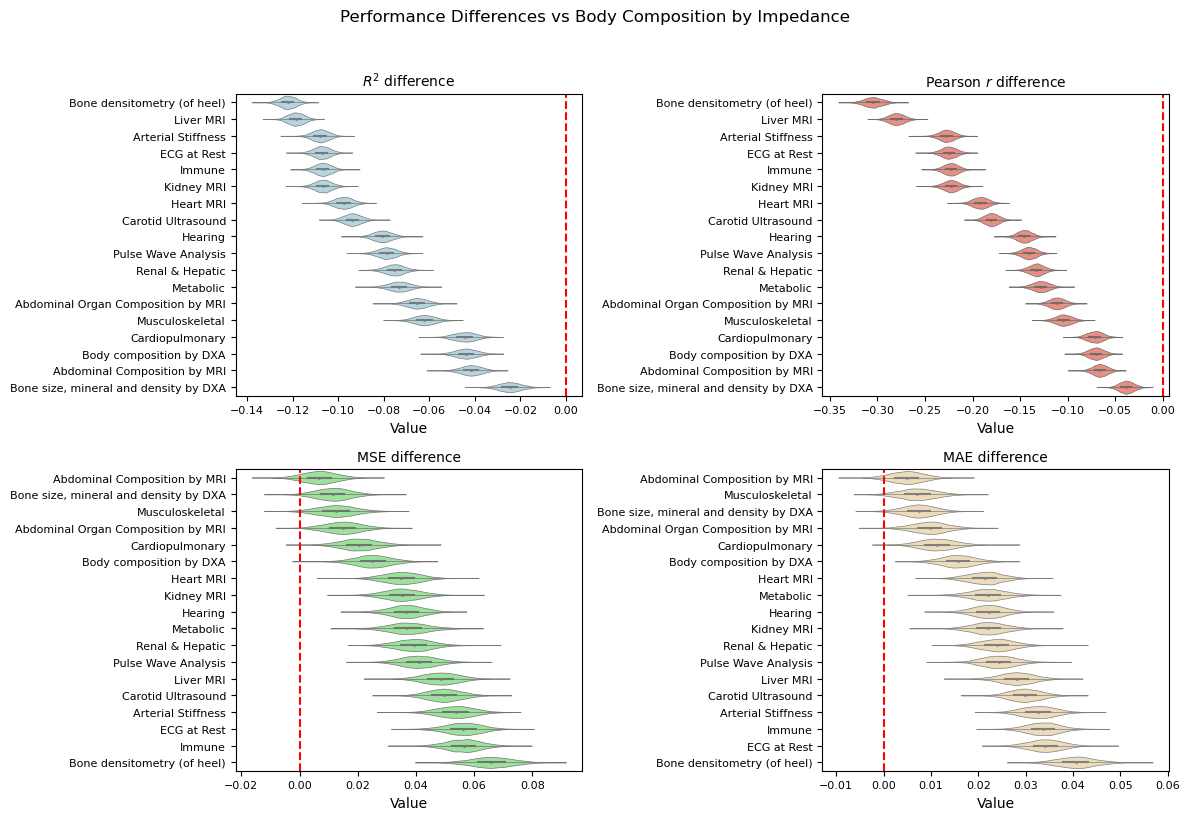

In [ ]:
# Plot top body body vs other body phenotypes
bootstrapping_path = '/UK_BB/brainbody/bootstrap/body'
delta_results_dir = os.path.join(bootstrapping_path, 'delta_results')
delta_files = [f for f in os.listdir(delta_results_dir) if f.startswith('delta_') and f.endswith('.csv')]
delta_dfs = {f.replace('.csv', ''): pd.read_csv(os.path.join(delta_results_dir, f)) for f in delta_files}

# Prepare data for plotting
metrics = {
    'delta_R2': {'title': '$R^2$ difference', 'color': 'lightblue'},
    'delta_r': {'title': 'Pearson $r$ difference', 'color': 'salmon'}, 
    'delta_MSE': {'title': 'MSE difference', 'color': 'lightgreen'},
    'delta_MAE': {'title': 'MAE difference', 'color': 'wheat'}
}

# Create figure
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, (metric, params) in enumerate(metrics.items()):
    # Combine all deltas for this metric
    all_data = []
    for mod_name, df in delta_dfs.items():
        if metric in df.columns:
            comparison_name = mod_name.replace('delta_', '').replace('_vs_body_composition_by_impedance', '')
            comparison_name = modality_map.get(comparison_name, comparison_name)
            for val in df[metric]:
                all_data.append({'Comparison': comparison_name, 'Value': val})
    
    if not all_data:
        continue
        
    plot_df = pd.DataFrame(all_data)
    
    # Sort by mean value
    sorted_order = plot_df.groupby('Comparison')['Value'].mean().sort_values().index
    
    # Create plot
    sns.violinplot(
        data=plot_df,
        x='Value',
        y='Comparison',
        order=sorted_order,
        ax=axs[i],
        color=params['color'],
        linewidth=0.5,
        linecolor="black"
    )
    
    axs[i].set_title(params['title'], fontsize=10)
    axs[i].axvline(x=0, color='red', linestyle='--')
    axs[i].set_ylabel('')
    axs[i].tick_params(axis='y', labelsize=8)
    axs[i].tick_params(axis='x', labelsize=8)

plt.suptitle('Performance Differences vs Body Composition by Impedance', y=1.02, fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(delta_results_dir, 'delta_comparisons.png'), dpi=300, bbox_inches='tight')
plt.show()

### Composite body vs the rest

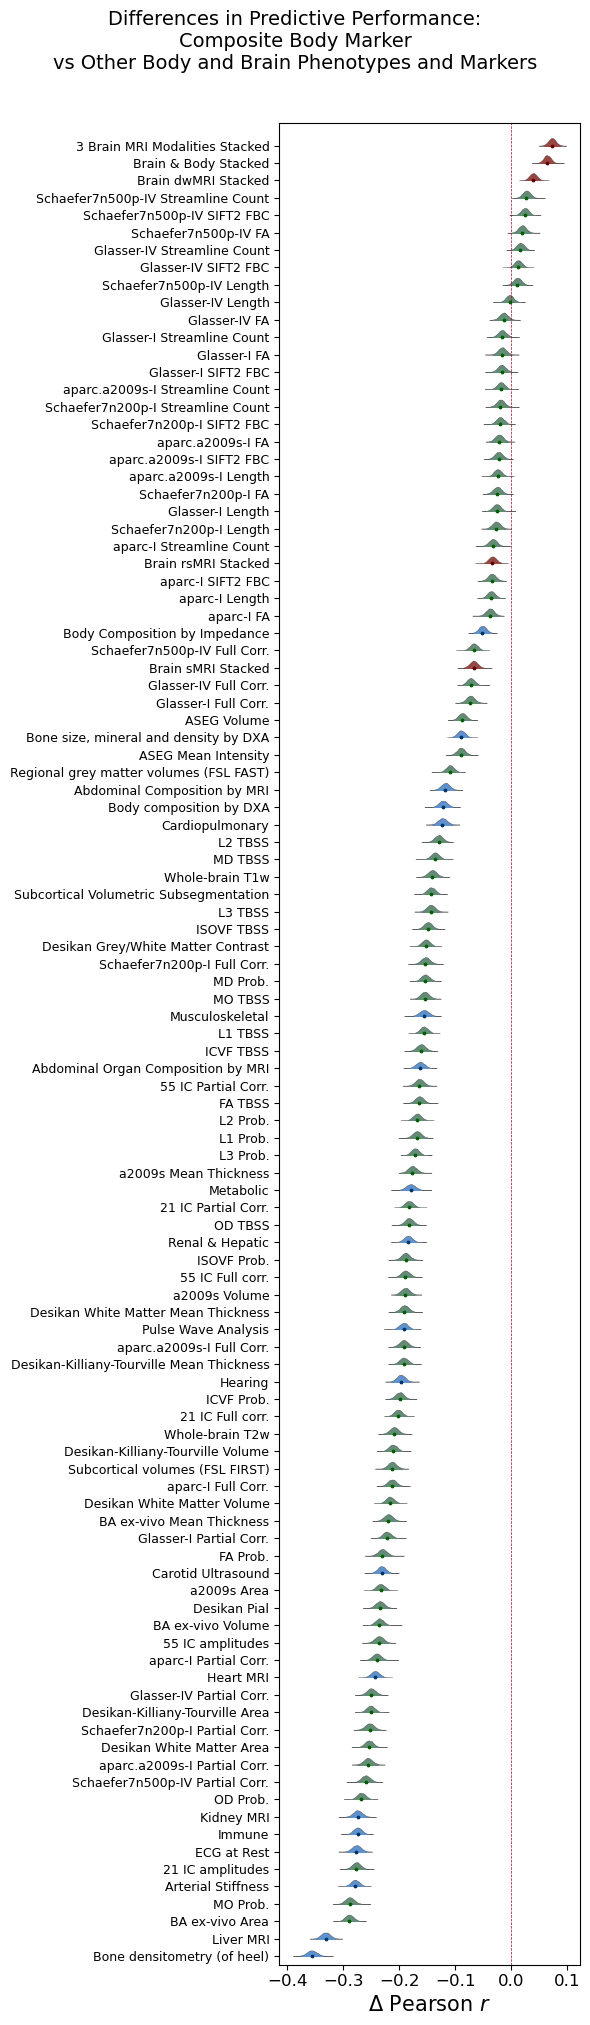

In [ ]:
# Plot composite body vs the rest
from matplotlib.collections import PolyCollection
bootstrapping_path = '/UK_BB/brainbody/bootstrap/body_vs_all'
os.makedirs(bootstrapping_path, exist_ok=True)

# Load directories
delta_dfs = {}
delta_dir_body = os.path.join(bootstrapping_path, 'delta_results_body')
delta_dir_brain = os.path.join(bootstrapping_path, 'delta_results_brain')
delta_dir_stacked = os.path.join(bootstrapping_path, 'delta_results_stacked')
violin_width = 0.9

# Load body individual results
if os.path.exists(delta_dir_body):
    delta_files = [f for f in os.listdir(delta_dir_body) if f.startswith('delta_') and f.endswith('.csv')]
    for f in delta_files:
        delta_dfs[f.replace('.csv', '')] = pd.read_csv(os.path.join(delta_dir_body, f))

# Load brain individual results
if os.path.exists(delta_dir_brain):
    delta_files = [f for f in os.listdir(delta_dir_brain) if f.startswith('delta_') and f.endswith('.csv')]
    for f in delta_files:
        delta_dfs[f.replace('.csv', '')] = pd.read_csv(os.path.join(delta_dir_brain, f))

# Load stacked results
if os.path.exists(delta_dir_stacked):
    delta_files = [f for f in os.listdir(delta_dir_stacked) if f.startswith('delta_') and f.endswith('.csv')]
    for f in delta_files:
        delta_dfs[f.replace('.csv', '')] = pd.read_csv(os.path.join(delta_dir_stacked, f))

# Prepare data for plotting - Pearson r
metric = 'delta_r'

# Define which modalities belong to which category
body_individual_modalities = modalities_body
brain_individual_modalities = modalities_brain
stacked_modalities = ['allmri', 'dwi', 'rs', 'smri', 'brain-body']

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(6, 20))

# Combine all deltas for Pearson r
all_data = []
for mod_name, df in delta_dfs.items():
    if metric in df.columns:
        # Extract comparison name
        # Remove 'delta_' and '_vs_body' or similar suffixes
        comparison_name = mod_name.replace('delta_', '').replace('_vs_body', '').replace('_individual', '')
        
        # Apply renaming
        comparison_name = modality_map.get(comparison_name, comparison_name)
        for val in df[metric]:
            all_data.append({'Comparison': comparison_name, 'Value': val})
    
if not all_data:
    print("No data found for plotting")
else:
    plot_df = pd.DataFrame(all_data)
    sorted_order = plot_df.groupby('Comparison')['Value'].median().sort_values().index

    # Determine colors based on modality type
    violin_colors = []
    for mod_name in sorted_order:
        # Get original name from reverse map
        reverse_modality_map = {v: k for k, v in modality_map.items()}
        original_name = reverse_modality_map.get(mod_name, mod_name)
        
        if original_name in stacked_modalities:
            violin_colors.append('#A73933FF')  # Red for stacked brain
        elif original_name in brain_individual_modalities:
            violin_colors.append('#5B9374FF')   # Green for individual brain
        else:  # body individual
            violin_colors.append('#4A90E2FF')   # Blue for individual body
    
    medians = plot_df.groupby('Comparison')['Value'].median().sort_values(ascending=False)

    # Create plot
    sns.violinplot(
        data=plot_df,
        x='Value',
        y='Comparison',
        order=sorted_order,
        ax=ax,
        palette=violin_colors,
        linewidth=0.3,
        linecolor="grey",
        width=violin_width,
        inner=None,
    )
    
    # Add median markers with different colors per category
    for j, modality in enumerate(sorted_order):
        median_val = medians[modality]
        reverse_modality_map = {v: k for k, v in modality_map.items()}
        original_name = reverse_modality_map.get(modality, modality)
        
        if original_name in stacked_modalities:
            marker_color = '#5E0000FF'  # Dark red for stacked
        elif original_name in brain_individual_modalities:
            marker_color = '#005E00FF'  # Dark green for brain individual
        else:  # body individual
            marker_color = '#003366FF'  # Dark blue for body individual
            
        ax.scatter(median_val, j, color=marker_color, s=3, zorder=5)

    ax.axvline(x=0, color='#A50026FF', linestyle='--', linewidth=0.5)
    ax.set_ylabel('')
    ax.set_xlabel('Δ Pearson $r$', fontsize=15)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', labelsize=12)
    
    # Control plot margins
    n_categories = len(sorted_order)
    ax.set_ylim(-0.5, n_categories + 0.3)

    xlim = ax.get_xlim()
    half_height = violin_width / 2.0

    # Get only the violin body collections
    violin_collections = [c for c in ax.collections if isinstance(c, PolyCollection)]
    violin_collections = violin_collections[:len(sorted_order)]

    for j, coll in enumerate(violin_collections):
        rect = patches.Rectangle(
        (xlim[0], j),
        (xlim[1] - xlim[0]),
        half_height + 1e-9,
        transform=ax.transData,
        facecolor='none',
        edgecolor='none',
        linewidth=0
        )
        rect.set_visible(False)          
        ax.add_patch(rect)
        coll.set_clip_path(rect)

plt.suptitle('Differences in Predictive Performance:\nComposite Body Marker\nvs Other Body and Brain Phenotypes and Markers', 
             y=1.01, fontsize=14)
plt.tight_layout()
#plt.savefig(os.path.join(figure_path, 'supplem', 'delta_r_body_stack_vs_all.png'), dpi=300, bbox_inches='tight')
plt.show()

### Top brain vs the rest

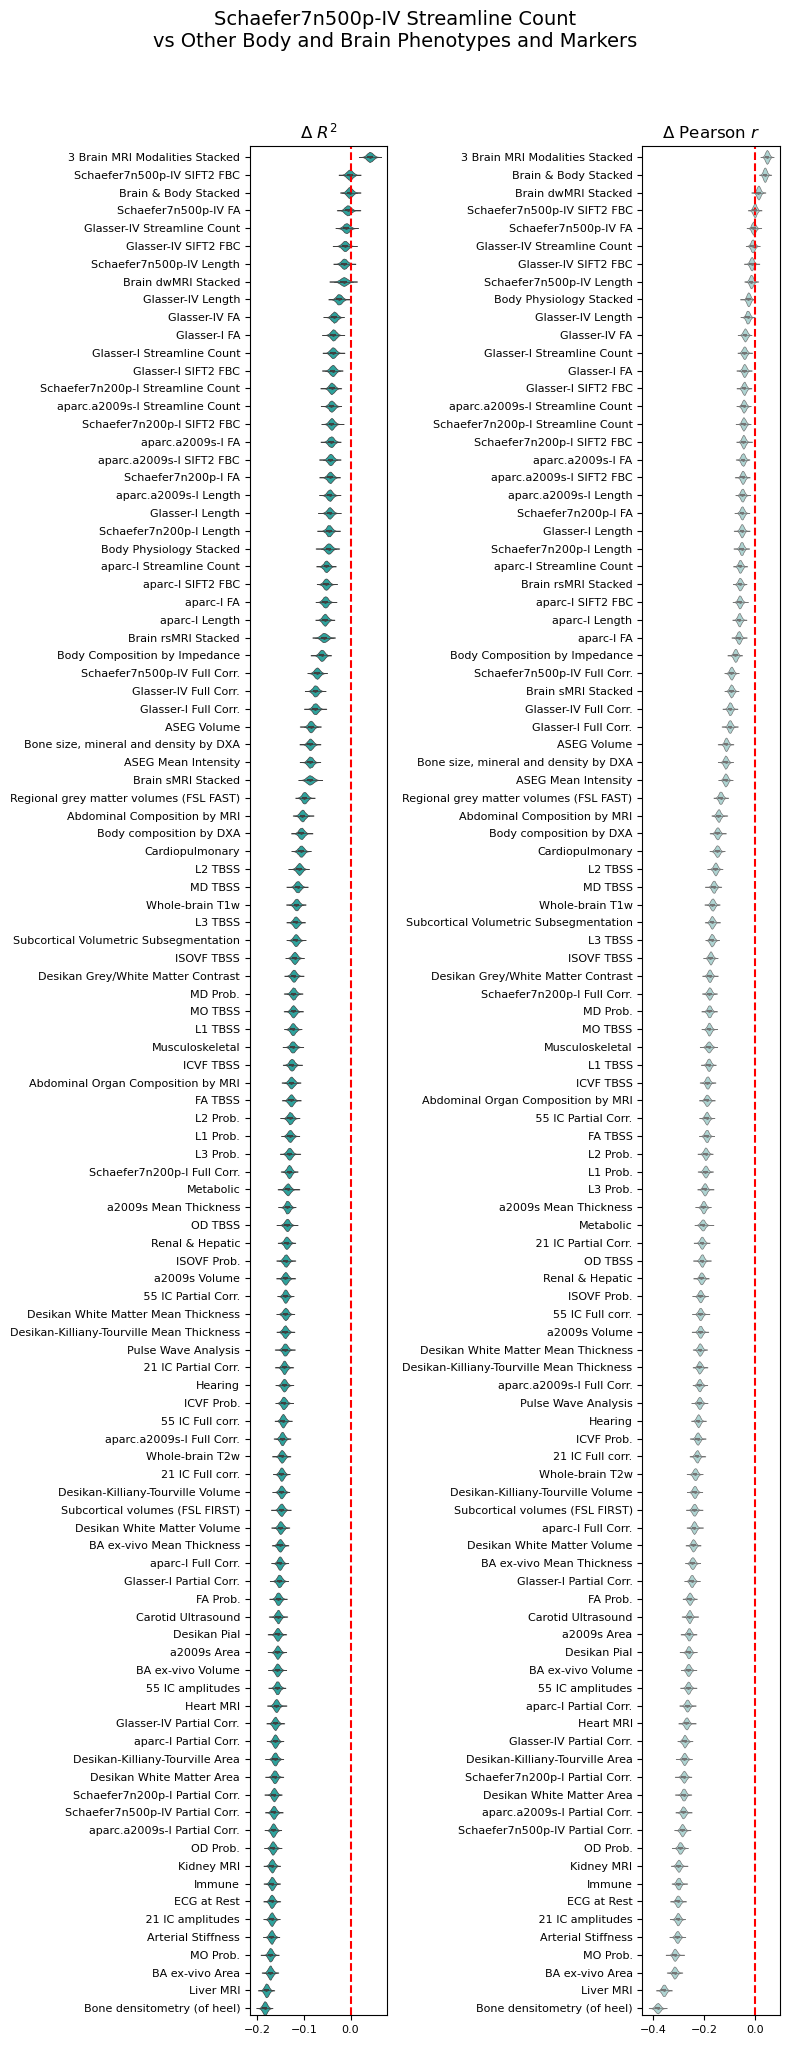

In [ ]:
# Plot top brain vs the rest
bootstrapping_path = '/UK_BB/brainbody/bootstrap/brain_vs_body'
os.makedirs(bootstrapping_path, exist_ok=True)

# Load both individual and stacked results
delta_dfs = {}
delta_dir_individual = os.path.join(bootstrapping_path, 'delta_results_individual')
delta_dir_stacked = os.path.join(bootstrapping_path, 'delta_results_stacked')

# Load individual results
if os.path.exists(delta_dir_individual):
    delta_files = [f for f in os.listdir(delta_dir_individual) if f.startswith('delta_') and f.endswith('.csv')]
    for f in delta_files:
        delta_dfs[f.replace('.csv', '')] = pd.read_csv(os.path.join(delta_dir_individual, f))

# Load stacked results
if os.path.exists(delta_dir_stacked):
    delta_files = [f for f in os.listdir(delta_dir_stacked) if f.startswith('delta_') and f.endswith('.csv')]
    for f in delta_files:
        delta_dfs[f.replace('.csv', '')] = pd.read_csv(os.path.join(delta_dir_stacked, f))

# Prepare data for plotting - Pearson r and R2
metrics = {
    'delta_R2': {'title': 'Δ $R^2$', 'color': '#1BB6AFFF'},
    'delta_r': {'title': 'Δ Pearson $r$', 'color': '#A7DBD8FF'}
}

# Create figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 20))
axs = axs.flatten()

for i, (metric, params) in enumerate(metrics.items()):
    # Combine all deltas for this metric
    all_data = []
    for mod_name, df in delta_dfs.items():
        if metric in df.columns:
            comparison_name = mod_name.replace('delta_', '').replace('_vs_Schaefer7n200p_Tian_S1_Streamline_Count_i2', '')
            # Apply renaming
            comparison_name = modality_map.get(comparison_name, comparison_name)
            for val in df[metric]:
                all_data.append({'Comparison': comparison_name, 'Value': val})
    
    if not all_data:
        continue
        
    plot_df = pd.DataFrame(all_data)
    
    # Sort by mean value
    sorted_order = plot_df.groupby('Comparison')['Value'].mean().sort_values().index
    
    # Create plot
    sns.violinplot(
        data=plot_df,
        x='Value',
        y='Comparison',
        order=sorted_order,
        ax=axs[i],
        color=params['color'],
        linewidth=0.5,
        linecolor="black"
    )
    
    axs[i].set_title(params['title'], fontsize=12)
    axs[i].axvline(x=0, color='red', linestyle='--')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].tick_params(axis='y', labelsize=8)
    axs[i].tick_params(axis='x', labelsize=8)
    
    # Control plot margins and spacing between labels
    #axs[i].margins(y=0.05)
    
    # Control plot margins
    n_categories = len(sorted_order)
    axs[i].set_ylim(-0.4, n_categories - 0.4)  # Tight bounds around categories

plt.suptitle('Schaefer7n500p-IV Streamline Count\nvs Other Body and Brain Phenotypes and Markers', 
             y=1.02, fontsize=14)
plt.tight_layout()
#plt.savefig(os.path.join(bootstrapping_path, 'delta_comparisons_R2_r_only.png'), dpi=300, bbox_inches='tight')
plt.show()

### Predictive performance of brain phenotypes

In [ ]:
# Define a plotting function
def plot_brain_performance_violins(results_dir, modality_type='body', fig_path=None,
                           violin_color=None, title=None, ylabel_fontsize=12, xlabel_fontsize=12,
                           xtick_fontsize=12, y_pad=None, shift=0.5,
                           label_offset=0.02, violin_width=0.8, figsize=(6, 10),
                           marker_color='#A73933FF', marker_size=8,
                           top_x_offset=None, bottom_x_offset=None,
                           top_y_offset=None, bottom_y_offset=None):


    # Set defaults based on modality type
    if modality_type == 'body':
        default_color = 'lightcoral'
        default_title = 'Predictive Performance of Body Physiology and Composition:/nBootstrap Distribution of Pearson $r$'
    else:  # brain
        default_color = 'lightblue'
        default_title = 'Predictive Performance of Neuroimaging Phenotypes:\nBootstrap Distribution of Pearson $r$'
    
    # Use provided values or defaults
    violin_color = violin_color or default_color
    title = title or default_title

    # Resolve independent offsets
    if top_x_offset is None:
        top_x_offset = label_offset
    if bottom_x_offset is None:
        bottom_x_offset = label_offset
    if top_y_offset is None:
        top_y_offset = 0.25 * violin_width
    if bottom_y_offset is None:
        bottom_y_offset = 0.15 * violin_width

    # Load files
    files = sorted([f for f in os.listdir(results_dir) if f.endswith('_bootstrapped.csv')])
    data = []
    
    for file in files:
        modality = file.replace('_bootstrapped.csv', '')
        df = pd.read_csv(os.path.join(results_dir, file))

        col = f'{modality}_r'
        if col in df.columns:
            r_vals = pd.to_numeric(df[col], errors='coerce').dropna()
            data.extend([{'modality': modality, 'r': r} for r in r_vals])
        else:
            print(f'Warning: expected column "{col}" not found in "{file}". Skipping.')

    df = pd.DataFrame(data)
    
    if df.empty:
        print(f"No {modality_type} data found - skipping plot")
        return
    
    # Compute median r per modality and sort descending
    medians = df.groupby('modality')['r'].median().sort_values(ascending=False)
    order = medians.index.tolist()

    # Determine display names for y-ticks via modality_map
    if 'modality_map' in globals() and isinstance(modality_map, dict):
        yticklabels = [modality_map.get(m, m) for m in order]
    else:
        yticklabels = order

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.violinplot(
        data=df,
        x='r', y='modality',
        order=order,
        ax=ax,
        color=violin_color,
        linewidth=1,
        cut=0,
        inner=None,
        width=violin_width
    )

    #####################################
    # Add extra space above the first and below the last violin (in category units)/
    y_pad = 0.5  # try 0.1–0.4; larger = more space
    n = len(order)
    # Default categorical limits are from -0.5 to n-0.5
    lower = shift - y_pad
    upper = n - shift + y_pad
    
    # Respect Seaborn's inverted y-axis (first category at the top)
    ylim = ax.get_ylim()
    if ylim[0] > ylim[1]:  # inverted
        ax.set_ylim(upper, lower)
    else:
        ax.set_ylim(lower, upper)
    #####################################

    # Add median markers for all modalities
    for j, modality in enumerate(order):
        median_val = medians[modality]
        ax.scatter(median_val, j, color=marker_color, s=marker_size, zorder=5)

    # Annotate median text for top and bottom modalities (independent offsets)
    top_idx = 0
    bottom_idx = len(order) - 1

    # Top annotation
    modality_top = order[top_idx]
    median_top = medians[modality_top]
    ax.text(median_top + top_x_offset, top_idx + top_y_offset, f'{median_top:.2f}',
            ha='left', va='center', fontsize=10, color='black')

    # Bottom annotation
    modality_bottom = order[bottom_idx]
    median_bottom = medians[modality_bottom]
    ax.text(median_bottom + bottom_x_offset, bottom_idx + bottom_y_offset, f'{median_bottom:.2f}',
            ha='left', va='center', fontsize=10, color='black')

    # Style axes (keep visible)
    for spine in ax.spines.values():
        spine.set_visible(True)
    ax.tick_params(axis='both', which='both', length=4)
    ax.tick_params(axis='x', labelsize=xtick_fontsize)
    ax.set_xlabel('Pearson $r$', fontsize=xlabel_fontsize)
    ax.set_ylabel('')

    # Apply custom y-tick labels
    ax.set_yticks(range(len(order)))
    ax.set_yticklabels(yticklabels, fontsize=ylabel_fontsize)

    # Vertical reference line at r = 0
    #ax.axvline(x=0, color='red', linestyle='--', alpha=0.7)

    # ---- Clip violins to show only the upper half ----
    xlim = ax.get_xlim()
    half_height = violin_width / 2.0

    violin_collections = [c for c in ax.collections if isinstance(c, PolyCollection)]
    violin_collections = violin_collections[:len(order)]
    
    ylim = ax.get_ylim()
    upper_is_towards_smaller_y = ylim[0] > ylim[1]
    
    for j, coll in enumerate(violin_collections):
        # If axis is inverted, upper half is [j - half_height, j]
        # # Otherwise, upper half is [j, j + half_height]
        rect_y = j - half_height if upper_is_towards_smaller_y else j
        
        rect = patches.Rectangle(
        (xlim[0], rect_y),
        xlim[1] - xlim[0],
        half_height + 1e-9,
        transform=ax.transData,
        facecolor='none',
        edgecolor='none',
        linewidth=0)
        
        rect.set_visible(False)
        ax.add_patch(rect)
        coll.set_clip_path(rect)


    ax.set_title(title, fontsize=17)
    plt.tight_layout()
    
    if fig_path:
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    
    plt.show()

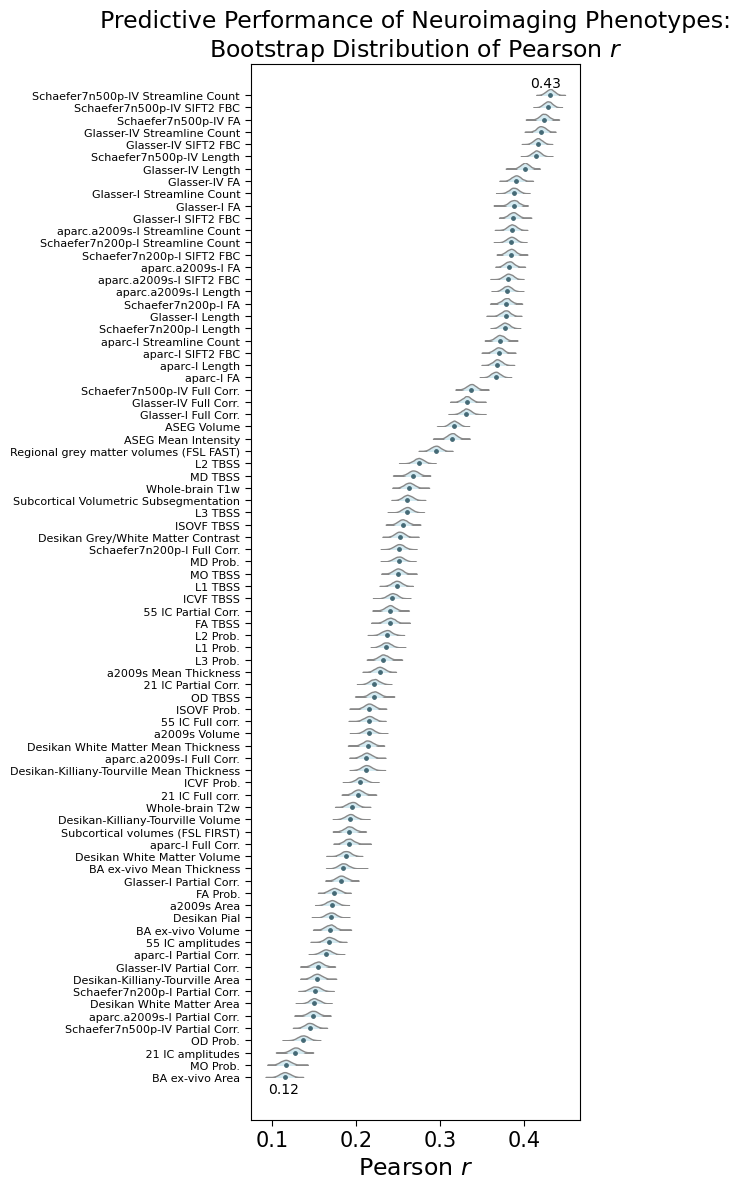

In [ ]:
# Plot brain performance
plot_brain_performance_violins(
    results_dir='/UK_BB/brainbody/bootstrap/brain/results',
    modality_type='brain',
    fig_path=os.path.join(fig_path, 'brain_performance.png'),
    ylabel_fontsize=8,
    xlabel_fontsize=17,
    violin_color='#D0EEF7FF',
    title=None,
    label_offset=0.02,      # default fallback for x-offsets if not provided
    violin_width=1,         # top half spans up to +0.5 above category center
    figsize=(6, 12),
    marker_color='#456A76FF',
    marker_size=6,
    xtick_fontsize=15,
    y_pad = 1,
    shift=-2,

    # Independent positions for top/bottom labels
    top_x_offset = -0.024,    # move top label left
    bottom_x_offset = -0.02, # move bottom label left

    top_y_offset = -1,      # move top label higher
    bottom_y_offset = +1   # move bottom label lower

)


# Display stacking results

In [ ]:
# Pool all results together and add SD: brain

five_folds = []
folds = range(0, 5)

modalities = [
    'smri',
    'dwi',
    'rs',
    'allmri'
]

modality_names = {
    'smri': 'sMRI',
    'dwi': 'dwMRI',
    'rs': 'rsMRI',
    'allmri': '3 Brain MRI Modalities Stacked'
}

def count_csv_rows(file_path):
    with open(file_path) as f:
        return sum(1 for _ in csv.reader(f)) - 1  # subtract header

def count_csv_columns(file_path):
    with open(file_path) as f:
        return len(next(csv.reader(f)))  # header length

algorithm = 'rf'
base_path = '/UK_BB/brainbody'
glob_mod = 'brain_stack'  # global mod name for saving
output_result_path = '/UK_BB/brainbody/result/2level'
os.makedirs(output_result_path, exist_ok=True)

for modality in modalities:
    stacking_path = os.path.join(base_path, f'stacking/brain/{modality}')

    for fold in folds:
        # Read the result file
        result_fp = os.path.join(
            stacking_path,
            f'folds/fold_{fold}/models/{modality}_{algorithm}_stacked_result_fold_{fold}.csv'
        )
        result = pd.read_csv(result_fp)
        
        # Paths for shapes
        test_data_path = os.path.join(
            stacking_path,
            f'features_test_level1_stacked_inner/features_test_level1_inner_g_matched_fold_{fold}.csv'
        )
        train_data_path = os.path.join(
            stacking_path,
            f'features_train_level1_stacked_inner/features_train_level1_inner_g_matched_fold_{fold}.csv'
        )
        
        # Efficient counts
        n_features = count_csv_columns(test_data_path) - 2  # subtract eid + g
        n_test = count_csv_rows(test_data_path)
        n_train = count_csv_rows(train_data_path)
        
        result['N Features'] = n_features
        result['N Train'] = n_train
        result['N Test'] = n_test
        
        # Rename modality
        modality_rename = modality_names.get(modality, modality)
        result['Modality'] = modality_rename
        
        # Domain
        if modality == 'smri':
            domain = 'sMRI'
        elif modality == 'dwi':
            domain = 'dwMRI'
        elif modality == 'rs':
            domain = 'rsMRI'
        elif modality == 'allmri':
            domain = 'MRI all'
        else:
            domain = 'Unknown'
        result['Domain'] = domain
        
        five_folds.append(result)

# Combine all folds across modalities
five_folds_all_modalities = pd.concat(five_folds, ignore_index=False)

# Normalize column names by removing underscores
five_folds_all_modalities.columns = [col.replace('_', ' ') for col in five_folds_all_modalities.columns]

# Mean + SD across folds

# Metrics expected in "result" CSVs
all_metrics = [
    'Test R2', 'Test Pearson r', 'Test MSE', 'Test MAE',
    'Train R2', 'Train Pearson r', 'Train MSE', 'Train MAE'
]
# Keep only those that exist to avoid KeyErrors
metrics = [m for m in all_metrics if m in five_folds_all_modalities.columns]

# Aggregation: mean & std for metrics; take first for counts
agg_spec = {m: ['mean', 'std'] for m in metrics}
for c in ['N Train', 'N Test', 'N Features']:
    if c in five_folds_all_modalities.columns:
        agg_spec[c] = 'first'

five_folds_all_modalities_mean = (
    five_folds_all_modalities
    .groupby(['Modality', 'Domain'])
    .agg(agg_spec)
)

# Flatten MultiIndex columns
five_folds_all_modalities_mean.columns = [
    (f"{col} {'Mean' if stat=='mean' else 'SD' if stat=='std' else ''}").strip()
    for col, stat in five_folds_all_modalities_mean.columns
]
five_folds_all_modalities_mean = five_folds_all_modalities_mean.reset_index()

# Rounding policy
round_map = {
    'Test R2 Mean': 5, 'Test R2 SD': 5,
    'Test Pearson r Mean': 4, 'Test Pearson r SD': 4,
    'Test MSE Mean': 4, 'Test MSE SD': 4,
    'Test MAE Mean': 4, 'Test MAE SD': 4,
    'Train R2 Mean': 4, 'Train R2 SD': 4,
    'Train Pearson r Mean': 4, 'Train Pearson r SD': 4,
    'Train MSE Mean': 4, 'Train MSE SD': 4,
    'Train MAE Mean': 4, 'Train MAE SD': 4
}
# Apply rounding only to present columns
present_round_map = {k: v for k, v in round_map.items() if k in five_folds_all_modalities_mean.columns}
if present_round_map:
    five_folds_all_modalities_mean = five_folds_all_modalities_mean.round(present_round_map)

# Ensure counts are ints (if present)
for c in ['N Test', 'N Train', 'N Features']:
    if c in five_folds_all_modalities_mean.columns:
        five_folds_all_modalities_mean[c] = five_folds_all_modalities_mean[c].astype(int)

# Sort by a primary metric if available
sort_key = 'Test R2 Mean' if 'Test R2 Mean' in five_folds_all_modalities_mean.columns else None
if sort_key:
    five_folds_all_modalities_mean = five_folds_all_modalities_mean.sort_values(by=sort_key, ascending=False)

# Display
with pd.option_context('display.max_rows', None):
    display(five_folds_all_modalities_mean.drop(columns='Domain'))

# Save outputs

# Sort raw folds by Test R2 (if present) before saving
if 'Test R2' in five_folds_all_modalities.columns:
    five_folds_all_modalities = five_folds_all_modalities.sort_values(by='Test R2', ascending=False)

five_folds_all_modalities.to_excel(
    os.path.join(output_result_path, f'2level_result-folds_{glob_mod}.xlsx'),
    index=False,
    engine='openpyxl'
)

# Save the Mean + SD table
five_folds_all_modalities_mean.to_excel(
    os.path.join(output_result_path, f'2level_result-mean_sd_{glob_mod}.xlsx'),
    index=False,
    engine='openpyxl'
)


Modality  Test R2 Mean  Test R2 SD  \
0  3 Brain MRI Modalities Stacked       0.22697     0.00727   
1                           dwMRI       0.17109     0.00366   
2                           rsMRI       0.12843     0.01200   
3                            sMRI       0.09834     0.01116   

   Test Pearson r Mean  Test Pearson r SD  Test MSE Mean  Test MSE SD  \
0               0.4770             0.0078         0.7722       0.0104   
1               0.4434             0.0041         0.8284       0.0124   
2               0.3708             0.0121         0.8707       0.0130   
3               0.3371             0.0145         0.9011       0.0235   

   Test MAE Mean  Test MAE SD  Train R2 Mean  Train R2 SD  \
0         0.6941       0.0026         0.8353       0.0309   
1         0.7201       0.0044         0.6883       0.0181   
2         0.7371       0.0046         0.8342       0.0437   
3         0.7485       0.0094         0.4108       0.0097   

   Train Pearson r Mean  Train Pearson r SD  Train MSE Mean  Train MSE SD  \
0                0.9194              0.0163          0.1647        0.0309   
1                0.8360              0.0103          0.3117        0.0181   
2                0.9159              0.0232          0.1658        0.0437   
3                0.6519              0.0077          0.5892        0.0097   

   Train MAE Mean  Train MAE SD  N Train  N Test  N Features  
0          0.3202        0.0316    20273    5073          81  
1          0.4436        0.0129    11360    5162          42  
2          0.3202        0.0442    20324    5085          18  
3          0.6075        0.0050    21710    5415          21

In [ ]:
# Pool all results together and add SD: body, outer
five_folds = []
folds = range(0,5)

modalities = [
    'body',
]

modality_names = {
    'body': 'Body Stacked',
}

def count_csv_rows(file_path):
    with open(file_path) as f:
        return sum(1 for row in csv.reader(f)) - 1  # subtract header

def count_csv_columns(file_path):
    with open(file_path) as f:
        return len(next(csv.reader(f)))  # just read header row

algorithm = '0' # 0 = rf ofr outer output
base_path = '/UK_BB/brainbody'
merge_type = 'outer'
glob_mod = f'body_stack_{merge_type}'
output_result_path = '/UK_BB/brainbody/result/2level'
os.makedirs(output_result_path, exist_ok=True)

for modality in modalities:
    stacking_path = os.path.join(base_path, f'stacking/{modality}')

    for fold in folds:
        # Read the result file
        result = pd.read_csv(
            os.path.join(
                stacking_path,
                f'folds/fold_{fold}/models/{modality}_{algorithm}_{merge_type}_stacked_result_fold_{fold}.csv'
            )
        )
            
        # Get number of features and subjects
        test_data_path = os.path.join(
            stacking_path,
            f'features_test_level1_stacked_outer/features_test_level1_outer_g_matched_fold_{fold}.csv'
        )
        train_data_path = os.path.join(
            stacking_path,
            f'features_train_level1_stacked_outer/features_train_level1_outer_g_matched_fold_{fold}.csv'
        )
        
        # Using the more efficient counting functions
        n_features = count_csv_columns(test_data_path) - 2  # subtracting eid and g columns
        n_test = count_csv_rows(test_data_path)
        n_train = count_csv_rows(train_data_path)
            
        result['N Features'] = n_features
        result['N Train'] = n_train
        result['N Test'] = n_test
            
        # Rename modality using the dictionary
        modality_rename = modality_names.get(modality, modality)
        result['Modality'] = modality_rename
            
        five_folds.append(result)

five_folds_all_modalities = pd.concat(five_folds, ignore_index=False)

# Remove underscores from column names
five_folds_all_modalities.columns = [col.replace('_', ' ') for col in five_folds_all_modalities.columns]

# Mean + SD across folds

# Metrics expected in "result" CSVs
all_metrics = [
    'Test R2', 'Test Pearson r', 'Test MSE', 'Test MAE',
    'Train R2', 'Train Pearson r', 'Train MSE', 'Train MAE'
]
# Keep only those that exist to avoid KeyErrors
metrics = [m for m in all_metrics if m in five_folds_all_modalities.columns]

# Aggregation: mean & std for metrics; take first for counts
agg_spec = {m: ['mean', 'std'] for m in metrics}
for c in ['N Train', 'N Test', 'N Features']:
    if c in five_folds_all_modalities.columns:
        agg_spec[c] = 'first'

five_folds_all_modalities_mean = (
    five_folds_all_modalities
    .groupby(['Modality'])
    .agg(agg_spec)
)

# Flatten MultiIndex columns
five_folds_all_modalities_mean.columns = [
    f"{col} {'Mean' if stat=='mean' else 'SD' if stat=='std' else ''}".strip()
    for col, stat in five_folds_all_modalities_mean.columns
]
five_folds_all_modalities_mean = five_folds_all_modalities_mean.reset_index()

# Rounding
round_map = {
    'Test R2 Mean': 3, 'Test R2 SD': 3,
    'Test Pearson r Mean': 2, 'Test Pearson r SD': 2,
    'Test MSE Mean': 3, 'Test MSE SD': 3,
    'Test MAE Mean': 3, 'Test MAE SD': 3,
    'Train R2 Mean': 3, 'Train R2 SD': 3,
    'Train Pearson r Mean': 2, 'Train Pearson r SD': 2,
    'Train MSE Mean': 2, 'Train MSE SD': 2,
    'Train MAE Mean': 2, 'Train MAE SD': 2
}
present_round_map = {k: v for k, v in round_map.items() if k in five_folds_all_modalities_mean.columns}
if present_round_map:
    five_folds_all_modalities_mean = five_folds_all_modalities_mean.round(present_round_map)

# Ensure counts are ints (if present)
for c in ['N Test', 'N Train', 'N Features']:
    if c in five_folds_all_modalities_mean.columns:
        five_folds_all_modalities_mean[c] = five_folds_all_modalities_mean[c].astype(int)

# Sort by a primary metric if available
if 'Test R2 Mean' in five_folds_all_modalities_mean.columns:
    five_folds_all_modalities_mean = five_folds_all_modalities_mean.sort_values(by='Test R2 Mean', ascending=False)

# Display the results
with pd.option_context('display.max_rows', None):
    display(five_folds_all_modalities_mean)

# Save final results
if 'Test R2' in five_folds_all_modalities.columns:
    five_folds_all_modalities = five_folds_all_modalities.sort_values(by='Test R2', ascending=False)

five_folds_all_modalities.to_excel(
    os.path.join(output_result_path, f'2level_result-folds_{glob_mod}.xlsx'),
    index=False,
    engine='openpyxl'
)

five_folds_all_modalities_mean.to_excel(
    os.path.join(output_result_path, f'2level_result-mean_sd_{glob_mod}.xlsx'),
    index=False,
    engine='openpyxl'
)


Modality  Test R2 Mean  Test R2 SD  Test Pearson r Mean  \
0  Body Stacked         0.163       0.012                  0.4   

   Test Pearson r SD  Test MSE Mean  Test MSE SD  Test MAE Mean  Test MAE SD  \
0               0.02          0.835        0.022          0.722        0.009   

   Train R2 Mean  Train R2 SD  Train Pearson r Mean  Train Pearson r SD  \
0          0.357        0.008                  0.62                0.01   

   Train MSE Mean  Train MSE SD  Train MAE Mean  Train MAE SD  N Train  \
0            0.64          0.01            0.63           0.0    25517   

   N Test  N Features  
0    6380          19

In [ ]:
# Pool all results together and add SD: brain + body, outer
five_folds = []
folds = range(0,5)

modalities = [
    'brain-body',
]

modality_names = {
    'brain-body': 'Body and Brain Stacked',
}

def count_csv_rows(file_path):
    with open(file_path) as f:
        return sum(1 for row in csv.reader(f)) - 1  # subtract header

def count_csv_columns(file_path):
    with open(file_path) as f:
        return len(next(csv.reader(f)))  # just read header row

algorithm = '0'  # 0 = rf for outer output
base_path = '/UK_BB/brainbody'
merge_type = 'outer'
glob_mod = f'brain_and_body_stack_{merge_type}'
output_result_path = '/UK_BB/brainbody/result/2level'
os.makedirs(output_result_path, exist_ok=True)

for modality in modalities:
    stacking_path = os.path.join(base_path, f'stacking/{modality}')

    for fold in folds:
        # Read the result file
        result = pd.read_csv(
            os.path.join(
                stacking_path,
                f'folds/fold_{fold}/models/{modality}_{algorithm}_{merge_type}_stacked_result_fold_{fold}.csv'
            )
        )
            
        # Get number of features and subjects
        test_data_path = os.path.join(
            stacking_path,
            f'features_test_level1_stacked_outer/features_test_level1_outer_g_matched_fold_{fold}.csv'
        )
        train_data_path = os.path.join(
            stacking_path,
            f'features_train_level1_stacked_outer/features_train_level1_outer_g_matched_fold_{fold}.csv'
        )
        
        # Using the more efficient counting functions
        n_features = count_csv_columns(test_data_path) - 2  # subtracting eid and g columns
        n_test = count_csv_rows(test_data_path)
        n_train = count_csv_rows(train_data_path)
            
        result['N Features'] = n_features
        result['N Train'] = n_train
        result['N Test'] = n_test
            
        # Rename modality using the dictionary
        modality_rename = modality_names.get(modality, modality)
        result['Modality'] = modality_rename
            
        five_folds.append(result)

five_folds_all_modalities = pd.concat(five_folds, ignore_index=False)

# Remove underscores from column names
five_folds_all_modalities.columns = [col.replace('_', ' ') for col in five_folds_all_modalities.columns]

# Mean + SD across folds

# Metrics expected in "result" CSVs
all_metrics = [
    'Test R2', 'Test Pearson r', 'Test MSE', 'Test MAE',
    'Train R2', 'Train Pearson r', 'Train MSE', 'Train MAE'
]
metrics = [m for m in all_metrics if m in five_folds_all_modalities.columns]

# Aggregation: mean & std for metrics; take first for counts
agg_spec = {m: ['mean', 'std'] for m in metrics}
for c in ['N Train', 'N Test', 'N Features']:
    if c in five_folds_all_modalities.columns:
        agg_spec[c] = 'first'

five_folds_all_modalities_mean = (
    five_folds_all_modalities
    .groupby(['Modality'])
    .agg(agg_spec)
)

# Flatten MultiIndex columns
five_folds_all_modalities_mean.columns = [
    f"{col} {'Mean' if stat=='mean' else 'SD' if stat=='std' else ''}".strip()
    for col, stat in five_folds_all_modalities_mean.columns
]
five_folds_all_modalities_mean = five_folds_all_modalities_mean.reset_index()

# Rounding policy
round_map = {
    'Test R2 Mean': 3, 'Test R2 SD': 3,
    'Test Pearson r Mean': 2, 'Test Pearson r SD': 2,
    'Test MSE Mean': 3, 'Test MSE SD': 3,
    'Test MAE Mean': 3, 'Test MAE SD': 3,
    'Train R2 Mean': 3, 'Train R2 SD': 3,
    'Train Pearson r Mean': 2, 'Train Pearson r SD': 2,
    'Train MSE Mean': 2, 'Train MSE SD': 2,
    'Train MAE Mean': 2, 'Train MAE SD': 2
}
present_round_map = {k: v for k, v in round_map.items() if k in five_folds_all_modalities_mean.columns}
if present_round_map:
    five_folds_all_modalities_mean = five_folds_all_modalities_mean.round(present_round_map)

# Ensure counts are ints (if present)
for c in ['N Test', 'N Train', 'N Features']:
    if c in five_folds_all_modalities_mean.columns:
        five_folds_all_modalities_mean[c] = five_folds_all_modalities_mean[c].astype(int)

# Sort by a primary metric if available
if 'Test R2 Mean' in five_folds_all_modalities_mean.columns:
    five_folds_all_modalities_mean = five_folds_all_modalities_mean.sort_values(by='Test R2 Mean', ascending=False)

# Display
with pd.option_context('display.max_rows', None):
    display(five_folds_all_modalities_mean)

# Save outputs
if 'Test R2' in five_folds_all_modalities.columns:
    five_folds_all_modalities = five_folds_all_modalities.sort_values(by='Test R2', ascending=False)

five_folds_all_modalities.to_excel(
    os.path.join(output_result_path, f'2level_result-folds_{glob_mod}.xlsx'),
    index=False,
    engine='openpyxl'
)

five_folds_all_modalities_mean.to_excel(
    os.path.join(output_result_path, f'2level_result-mean_sd_{glob_mod}.xlsx'),
    index=False,
    engine='openpyxl'
)


Modality  Test R2 Mean  Test R2 SD  Test Pearson r Mean  \
0  Body and Brain Stacked         0.218       0.003                 0.47   

   Test Pearson r SD  Test MSE Mean  Test MSE SD  Test MAE Mean  Test MAE SD  \
0                0.0          0.781        0.011          0.698        0.003   

   Train R2 Mean  Train R2 SD  Train Pearson r Mean  Train Pearson r SD  \
0          0.706        0.022                  0.85                0.01   

   Train MSE Mean  Train MSE SD  Train MAE Mean  Train MAE SD  N Train  \
0            0.29          0.02             0.4          0.02    25517   

   N Test  N Features  
0    6380         100